In [80]:
#Import Required Libraries
import numpy as np
import os
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
import gc
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AutoReg
from scipy.signal import lfilter
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from itertools import product
from statsmodels.tsa.vector_ar.vecm import select_order
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from pandas.tseries.offsets import QuarterEnd
from scipy.special import gammaln

#ARIMA and Time Series
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

#ARFIMA from ARCH package
from arch.univariate import ARX
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import jarque_bera
from scipy.stats import chi2
from scipy.stats import norm

#*** Haven't Chosen Which Ones Yet ***
from pandas.tseries.offsets import QuarterEnd

from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

# Optional import for XGBoost
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from scipy.special import gammaln
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from statsmodels.tsa.vector_ar.vecm import VECM
from pandas.tseries.offsets import QuarterEnd
from itertools import combinations
from sklearn.linear_model import LinearRegression

In [3]:
#Importing the headline CPI
df1 = pd.read_csv('/Users/nitaycarmi/Desktop/URSS Project/Datasets/Consumer Price Index All Items Total for United Kingdom .csv', parse_dates=['observation_date'])
df1.rename(columns={'observation_date': 'Date', 'GBRCPALTT01IXNBM': 'CPI Headline'}, inplace=True)

In [4]:
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace=True)
print(df1.head())

            CPI Headline
Date                    
1960-01-01      5.611997
1960-02-01      5.611997
1960-03-01      5.601784
1960-04-01      5.632423
1960-05-01      5.632423


In [5]:
#Resample to quarterly frequency using mean of months in each quarter (S&W 2007)
df_quarterly1 = df1.resample('QE').mean()
print(df_quarterly1.head())

            CPI Headline
Date                    
1960-03-31      5.608593
1960-06-30      5.642636
1960-09-30      5.651146
1960-12-31      5.710722
1961-03-31      5.741361


In [6]:
#Rquarterly Inflation as log differences (S&W 2007)
df_quarterly1['log_CPI'] = np.log(df_quarterly1['CPI Headline'])
df_quarterly1['Inflation'] = df_quarterly1['log_CPI'].diff()
df_quarterly1.dropna(inplace=True)
print(df_quarterly1[['CPI Headline', 'Inflation']].head())

            CPI Headline  Inflation
Date                               
1960-06-30      5.642636   0.006051
1960-09-30      5.651146   0.001507
1960-12-31      5.710722   0.010487
1961-03-31      5.741361   0.005351
1961-06-30      5.812851   0.012375


In [7]:
#FINAL INFLATION (log differenced)
df_quarterly1 = df_quarterly1[['Inflation']]
print(df_quarterly1.head())

            Inflation
Date                 
1960-06-30   0.006051
1960-09-30   0.001507
1960-12-31   0.010487
1961-03-31   0.005351
1961-06-30   0.012375


In [8]:
#Importing the Unemployment 16+ Seasonally Adjusted and making it quarterly (S&W 2007)
df2 = pd.read_csv('/Users/nitaycarmi/Desktop/URSS Project/Datasets/unemployment rate (16+, seasonally adjusted).csv',
                 skiprows=62,
                 header=None,
                 names=['Quarter', 'Unemployment Rate'])
df2['Quarter'] = pd.to_datetime(df2['Quarter'].str.replace(' ', '-')).dt.to_period('Q')
print(df2.head())

  Quarter  Unemployment Rate
0  1971Q1                3.8
1  1971Q2                4.1
2  1971Q3                4.2
3  1971Q4                4.4
4  1972Q1                4.5


/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_5261/2535781736.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['Quarter'] = pd.to_datetime(df2['Quarter'].str.replace(' ', '-')).dt.to_period('Q')


In [9]:
#Compute the two sided umeployment gap (S&W 2007)
# Calculate the 80-quarter centered moving average (two-sided gap)
df2['Unemp_MA80'] = df2['Unemployment Rate'].rolling(window=80, center=True, min_periods=40).mean()
# The unemployment gap is the difference between the rate and its long-run trend
df2['Unemp_Gap_2sided'] = df2['Unemployment Rate'] - df2['Unemp_MA80']
print(df2.head())

  Quarter  Unemployment Rate  Unemp_MA80  Unemp_Gap_2sided
0  1971Q1                3.8    4.902500         -1.102500
1  1971Q2                4.1    5.000000         -0.900000
2  1971Q3                4.2    5.109524         -0.909524
3  1971Q4                4.4    5.220930         -0.820930
4  1972Q1                4.5    5.334091         -0.834091


In [10]:
#Importing the Composite leading indicator (CLI) and making it quarterly (S&W 2007)
df3 = pd.read_csv('/Users/nitaycarmi/Desktop/URSS Project/Datasets/OECD Composite Leading Indicator (CLI) for the UK.csv',
                 skiprows=3,
                 header=None,
                 names=['Quarter', 'CLI']
                )

In [11]:
# 1. Convert 'Quarter' to datetime
df3['Date'] = pd.to_datetime(df3['Quarter'])

# 2. Set 'Date' as index
df3.set_index('Date', inplace=True)

# 3. Resample quarterly (quarter end) and take the mean of CLI only
df_quarterly3 = df3['CLI'].resample('QE').mean()

df_quarterly3 = df_quarterly3.to_frame(name='CLI')
print(df_quarterly3.head(50))
#No log needed as it is a cyclical variable anyways

                   CLI
Date                  
1974-06-30   94.910010
1974-09-30   94.199443
1974-12-31   93.500663
1975-03-31   94.311733
1975-06-30   96.163850
1975-09-30   97.719447
1975-12-31   99.127510
1976-03-31  100.643733
1976-06-30  101.114867
1976-09-30  100.183643
1976-12-31   99.490340
1977-03-31   99.987627
1977-06-30  101.326133
1977-09-30  102.695267
1977-12-31  103.221467
1978-03-31  103.014800
1978-06-30  102.935033
1978-09-30  103.153167
1978-12-31  102.817833
1979-03-31  102.871033
1979-06-30  102.755067
1979-09-30  101.059433
1979-12-31   99.757567
1980-03-31   98.571003
1980-06-30   97.248530
1980-09-30   96.488737
1980-12-31   96.864587
1981-03-31   98.207463
1981-06-30   99.185737
1981-09-30   98.918690
1981-12-31   98.494907
1982-03-31   98.473567
1982-06-30   98.755830
1982-09-30   99.328610
1982-12-31  100.191357
1983-03-31  100.905133
1983-06-30  101.631467
1983-09-30  102.022467
1983-12-31  101.985500
1984-03-31  101.868233
1984-06-30  101.331633
1984-09-30 

In [12]:
#Importing the Index of Building Permits to four decimal places and making it quarterly (S&W 2007)
df4 = pd.read_excel('/Users/nitaycarmi/Desktop/URSS Project/Datasets/Building Permits.xlsx', sheet_name='1a',
                     skiprows=5
                     )
#Filter to the specific column I need (completed all dwellings)
df_filtered4 = df4[['Period', 'Completed - All Dwellings']]

df4['Completed - All Dwellings'] = pd.to_numeric(df4['Completed - All Dwellings'], errors='coerce')
print(df4[['Period', 'Completed - All Dwellings']].head(10))
print(df4['Completed - All Dwellings'].dtype)  # should now be float64

#Convert period to a proper quarterly datetime format
def parse_quarter(period_str):
    quarter_map = {
        'Jan': 'Q1',
        'Apr': 'Q2',
        'Jul': 'Q3',
        'Oct': 'Q4'
    }
    try:
        # Example period_str: "Jan - Mar 1978"
        parts = period_str.split()
        # parts = ['Jan', '-', 'Mar', '1978']

        start_month = parts[0]   # 'Jan'
        year = parts[-1]         # '1978'
        quarter = quarter_map.get(start_month)
        if quarter is None:
            return None
        return f'{year}{quarter}'
    except Exception:
        return None


df_filtered4.loc[:, 'Period'] = df_filtered4['Period'].apply(parse_quarter)
df_filtered4.loc[:, 'Period'] = pd.PeriodIndex(df_filtered4['Period'], freq='Q')

           Period  Completed - All Dwellings
0  Jan - Mar 1978                    69160.0
1  Apr - Jun 1978                    74510.0
2  Jul - Sep 1978                    69750.0
3  Oct - Dec 1978                    75140.0
4  Jan - Mar 1979                    52420.0
5  Apr - Jun 1979                    59560.0
6  Jul - Sep 1979                    58420.0
7  Oct - Dec 1979                    81310.0
8  Jan - Mar 1980                    58950.0
9  Apr - Jun 1980                    59050.0
float64


In [13]:
# Assuming df_filtered already has 'Completed - All Dwellings' as float and no NaNs FINAL
# Ensure numeric conversion
df_filtered4['Completed - All Dwellings'] = pd.to_numeric(df_filtered4['Completed - All Dwellings'], errors='coerce')

# Filter out non-positive or NaN values before logging
mask = df_filtered4['Completed - All Dwellings'] > 0
df_filtered4 = df_filtered4[mask].copy()

# Compute log
df_filtered4['Log_Building_Permits'] = np.log(df_filtered4['Completed - All Dwellings'])

/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_5261/606412902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered4['Completed - All Dwellings'] = pd.to_numeric(df_filtered4['Completed - All Dwellings'], errors='coerce')


In [14]:
def one_sided_gap_filter(log_series, ar_lags=4, forecast_horizon=80, ma_window=80):
    import numpy as np
    import pandas as pd
    from statsmodels.tsa.ar_model import AutoReg
    
    # Step 1: Fit AR(4) model
    ar_model = AutoReg(log_series, lags=ar_lags, old_names=False).fit()
    
    # Step 2: Recursively forecast future values
    forecast = []
    current_data = log_series.values.copy()
    for _ in range(forecast_horizon):
        recent_data = current_data[-ar_lags:]
        X = np.r_[1, recent_data[::-1]]  # intercept + reversed lags
        next_val = np.dot(ar_model.params, X)
        forecast.append(next_val)
        current_data = np.append(current_data, next_val)
    
    # Step 3: Extended series (original + forecast)
    extended_series = np.concatenate([log_series.values, forecast])
    
    # Step 4: One-sided moving average (rolling mean looking backward)
    extended_series_pd = pd.Series(extended_series)
    trend = extended_series_pd.rolling(window=ma_window, min_periods=ma_window).mean().values
    
    # Step 5: Extract trend corresponding to original series length
    trend_original = trend[:len(log_series)]
    
    # Step 5a: Fill initial NaNs in trend (before gap calculation)
    if np.isnan(trend_original).any():
        first_valid_idx = np.argmax(~np.isnan(trend_original))
        trend_original[:first_valid_idx] = trend_original[first_valid_idx]
    
    # Step 6: Calculate cyclical component (gap)
    gap = log_series.values - trend_original
    
    # Return pandas Series with original index
    gap_series = pd.Series(gap, index=log_series.index)
    trend_series = pd.Series(trend_original, index=log_series.index)
    
    return gap_series, trend_series

In [15]:
log_series_filled4 = df_filtered4['Log_Building_Permits'].ffill().bfill()
gap, trend = one_sided_gap_filter(log_series_filled4)


print(trend.head(10))
print(gap.head(10))
print("Gap mean:", gap.mean())

0    10.853982
1    10.853982
2    10.853982
3    10.853982
4    10.853982
5    10.853982
6    10.853982
7    10.853982
8    10.853982
9    10.853982
dtype: float64
0    0.290196
1    0.364706
2    0.298690
3    0.373126
4    0.013061
5    0.140757
6    0.121431
7    0.452042
8    0.130463
9    0.132157
dtype: float64
Gap mean: -0.02373635618322464


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [16]:
#Importing the Gross Domestic Product: chained volume measures: Seasonally adjusted (S&W 2007)
df5 = pd.read_csv('/Users/nitaycarmi/Desktop/URSS Project/Datasets/Gross Domestic Product chained volume measures Seasonally adjusted.csv',
                 skiprows=85,
                 header=None,
                 names=['Quarter','GDP Volume']
                )
df5['Log_GDP'] = np.log(df5['GDP Volume'])
df5['GDP_Growth'] = df5['Log_GDP'].diff()

In [17]:
print(df5.head())

   Quarter  GDP Volume    Log_GDP  GDP_Growth
0  1955 Q1      134886  11.812185         NaN
1  1955 Q2      134924  11.812467    0.000282
2  1955 Q3      137592  11.832048    0.019581
3  1955 Q4      136813  11.826370   -0.005678
4  1956 Q1      138343  11.837491    0.011121


In [18]:
# Keep only the GDP_Growth column (and optionally the Quarter for reference)
df_gdp_growth5 = df5[['Quarter', 'GDP_Growth']].copy()

# If you want just the series without Quarter
gdp_growth_series = df5['GDP_Growth'].copy()
df5 = df5[['Quarter', 'GDP_Growth']]
print(df5.head())

   Quarter  GDP_Growth
0  1955 Q1         NaN
1  1955 Q2    0.000282
2  1955 Q3    0.019581
3  1955 Q4   -0.005678
4  1956 Q1    0.011121


In [19]:
print(df5.head())
print(df5.columns)

   Quarter  GDP_Growth
0  1955 Q1         NaN
1  1955 Q2    0.000282
2  1955 Q3    0.019581
3  1955 Q4   -0.005678
4  1956 Q1    0.011121
Index(['Quarter', 'GDP_Growth'], dtype='object')


In [20]:
#Importing the Index of Production and Sectors to 4 decimal places Seasonally adjusted (S&W 2007)
df6 = pd.read_excel('/Users/nitaycarmi/Desktop/URSS Project/Datasets/Index of Production and industry sectors to four decimal places.xlsx',
                   sheet_name="IoP and Sectors to 4dp",
                   skiprows=7
                )

df6 = df6.iloc[:, [0, 1]]
df6.columns = ['Date', 'Production_industries']
df6 = df6.dropna()

df6['Date'] = pd.to_datetime(df6['Date'], format='%Y%b')
print(df6.head())

        Date  Production_industries
0 1997-01-01                85.6482
1 1997-02-01                85.8215
2 1997-03-01                84.8495
3 1997-04-01                86.8219
4 1997-05-01                86.3188


In [21]:
# Ensure Date is datetime (already done, but safe check)
df6['Date'] = pd.to_datetime(df6['Date'])

# Set Date as index
df6 = df6.set_index('Date')

# Resample to quarterly frequency, taking the average of the three months
df_quarterly6 = df6.resample('QE').mean()

# Reset index so Date is a column again
df_quarterly6 = df_quarterly6.reset_index()

print(df_quarterly6.head())

        Date  Production_industries
0 1997-03-31              85.439733
1 1997-06-30              86.589000
2 1997-09-30              87.871233
3 1997-12-31              89.169800
4 1998-03-31              89.978833


In [22]:
#Log transform
df_quarterly6['log_Production'] = np.log(df_quarterly6['Production_industries'])
print(df_quarterly6[['Date', 'log_Production']].head(5))

        Date  log_Production
0 1997-03-31        4.447811
1 1997-06-30        4.461173
2 1997-09-30        4.475872
3 1997-12-31        4.490542
4 1998-03-31        4.499574


In [23]:
#ADF function
def adf_test(series, signif=0.05, name='Series'):
    print(f'Augmented Dickey-Fuller Test: {name}')
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {p_value:.4f}')
    if p_value <= signif:
        print(f" => The series '{name}' is likely stationary (reject H0 of unit root)")
    else:
        print(f" => The series '{name}' is likely non-stationary (fail to reject H0)")
    print('-----------------------')

In [24]:
#KPSS function
def kpss_test(series, **kw):
    """
    Perform KPSS test and print results.
    
    Parameters:
    series : pandas Series or numpy array
        The time series to test.
    **kw : additional keyword arguments for kpss() function.
    
    Returns:
    None
    """
    statistic, p_value, lags, critical_values = kpss(series, **kw)
    
    print(f'KPSS Test:')
    print(f'KPSS Statistic: {statistic:.4f}')
    print(f'p-value: {p_value:.4f}')
    print(f'num lags: {lags}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'  {key} : {value}')
    
    if p_value < 0.05:
        print(" => The series is likely NON-stationary (reject H0 of stationarity).")
    else:
        print(" => The series is likely STATIONARY (fail to reject H0 of stationarity).")


In [25]:
#ADF and KPSS test for the CPI
adf_test(df_quarterly1[['Inflation']], name='Inflation')
kpss_test(df_quarterly1[['Inflation']])

Augmented Dickey-Fuller Test: Inflation
ADF Statistic: -1.4678
p-value: 0.5494
 => The series 'Inflation' is likely non-stationary (fail to reject H0)
-----------------------
KPSS Test:
KPSS Statistic: 0.8548
p-value: 0.0100
num lags: 9
Critical Values:
  10% : 0.347
  5% : 0.463
  2.5% : 0.574
  1% : 0.739
 => The series is likely NON-stationary (reject H0 of stationarity).


/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_5261/4071871419.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, **kw)


In [26]:
#ADF and KPSS test for the Unemployment Gap (two-sided) 
adf_test(df2['Unemp_Gap_2sided'], name='Unemp_Gap_2sided')
kpss_test(df2['Unemp_Gap_2sided'])

Augmented Dickey-Fuller Test: Unemp_Gap_2sided
ADF Statistic: -6.7206
p-value: 0.0000
 => The series 'Unemp_Gap_2sided' is likely stationary (reject H0 of unit root)
-----------------------
KPSS Test:
KPSS Statistic: 0.0278
p-value: 0.1000
num lags: 18
Critical Values:
  10% : 0.347
  5% : 0.463
  2.5% : 0.574
  1% : 0.739
 => The series is likely STATIONARY (fail to reject H0 of stationarity).


/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_5261/4071871419.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, **kw)


In [27]:
#ADF and KPSS test for CLI (no log needed)
adf_test(df3['CLI'], name='CLI')
kpss_test(df3['CLI'])

Augmented Dickey-Fuller Test: CLI
ADF Statistic: -6.4282
p-value: 0.0000
 => The series 'CLI' is likely stationary (reject H0 of unit root)
-----------------------
KPSS Test:
KPSS Statistic: 0.1505
p-value: 0.1000
num lags: 15
Critical Values:
  10% : 0.347
  5% : 0.463
  2.5% : 0.574
  1% : 0.739
 => The series is likely STATIONARY (fail to reject H0 of stationarity).


/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_5261/4071871419.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, **kw)


In [28]:
#ADF and KPSS test for Building Permits
adf_test(gap, name='Log_Building_Permits Gap (one-sided)')
kpss_test(gap)

Augmented Dickey-Fuller Test: Log_Building_Permits Gap (one-sided)
ADF Statistic: -3.4154
p-value: 0.0104
 => The series 'Log_Building_Permits Gap (one-sided)' is likely stationary (reject H0 of unit root)
-----------------------
KPSS Test:
KPSS Statistic: 0.2056
p-value: 0.1000
num lags: 8
Critical Values:
  10% : 0.347
  5% : 0.463
  2.5% : 0.574
  1% : 0.739
 => The series is likely STATIONARY (fail to reject H0 of stationarity).


/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_5261/4071871419.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, **kw)


In [29]:
#ADF and KPSS test for Building Permits difference
gap_diff = gap.diff().dropna()
adf_test(gap_diff, name='Diff of Log_Building_Permits Gap')
kpss_test(gap_diff)


Augmented Dickey-Fuller Test: Diff of Log_Building_Permits Gap
ADF Statistic: -4.5431
p-value: 0.0002
 => The series 'Diff of Log_Building_Permits Gap' is likely stationary (reject H0 of unit root)
-----------------------
KPSS Test:
KPSS Statistic: 0.1602
p-value: 0.1000
num lags: 19
Critical Values:
  10% : 0.347
  5% : 0.463
  2.5% : 0.574
  1% : 0.739
 => The series is likely STATIONARY (fail to reject H0 of stationarity).


/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_5261/4071871419.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, **kw)


In [30]:
#ADF and KPSS test for Gross Domestic Product
# Drop NaNs before test
adf_test(df5['GDP_Growth'].dropna(), name='GDP_Growth')
kpss_test(df5['GDP_Growth'].dropna())

Augmented Dickey-Fuller Test: GDP_Growth
ADF Statistic: -9.3470
p-value: 0.0000
 => The series 'GDP_Growth' is likely stationary (reject H0 of unit root)
-----------------------
KPSS Test:
KPSS Statistic: 0.2070
p-value: 0.1000
num lags: 4
Critical Values:
  10% : 0.347
  5% : 0.463
  2.5% : 0.574
  1% : 0.739
 => The series is likely STATIONARY (fail to reject H0 of stationarity).


/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_5261/4071871419.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, **kw)


In [31]:
#ADF and KPSS test for Index of log Production
adf_test(df_quarterly6['log_Production'], name='log_Production')
kpss_test(df_quarterly6['log_Production'])

Augmented Dickey-Fuller Test: log_Production
ADF Statistic: -2.5647
p-value: 0.1005
 => The series 'log_Production' is likely non-stationary (fail to reject H0)
-----------------------
KPSS Test:
KPSS Statistic: 0.1645
p-value: 0.1000
num lags: 6
Critical Values:
  10% : 0.347
  5% : 0.463
  2.5% : 0.574
  1% : 0.739
 => The series is likely STATIONARY (fail to reject H0 of stationarity).


/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_5261/4071871419.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, **kw)


In [32]:
#ADF and KPSS test for Index of log Building Permits (NOT GAP)
adf_test(df_filtered4['Log_Building_Permits'], name='log_Building_Permits')
kpss_test(df_filtered4['Log_Building_Permits'])

Augmented Dickey-Fuller Test: log_Building_Permits
ADF Statistic: -2.7418
p-value: 0.0671
 => The series 'log_Building_Permits' is likely non-stationary (fail to reject H0)
-----------------------
KPSS Test:
KPSS Statistic: 0.7342
p-value: 0.0104
num lags: 8
Critical Values:
  10% : 0.347
  5% : 0.463
  2.5% : 0.574
  1% : 0.739
 => The series is likely NON-stationary (reject H0 of stationarity).


In [33]:
#Cointegration test on non stationary variables
I1_vars = pd.concat([
    df_filtered4['Log_Building_Permits'],  # I(1) log-level permits
    df_quarterly6['log_Production']        # I(1) log-level production
], axis=1).dropna()

johansen_test = coint_johansen(I1_vars, det_order=0, k_ar_diff=1)

print("Trace Statistic:", johansen_test.lr1)
print("Critical Values (trace):", johansen_test.cvt)
print("Max Eigen Statistic:", johansen_test.lr2)
print("Critical Values (max eigen):", johansen_test.cvm)

Trace Statistic: [20.21611721  5.71254241]
Critical Values (trace): [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Max Eigen Statistic: [14.5035748   5.71254241]
Critical Values (max eigen): [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [34]:
#Makes sure all datasets have the same type of index for their dates

# Example: permits & production already quarterly? Create DatetimeIndex:
I1_vars.index = pd.date_range(start="1995-01-01", periods=len(I1_vars), freq="QE")

# Convert unemployment gap (assuming monthly) → quarterly average
# Set a proper DatetimeIndex for df2
df2.index = pd.date_range(start="1974-06-01", periods=len(df2), freq="ME")
df2_q = df2['Unemp_Gap_2sided'].resample("QE").mean()

# Convert CLI (already monthly) → quarterly average
df3_q = df3['CLI'].resample("QE").mean()

# Convert GDP growth (if quarterly data is intended)
df5_q = df5['GDP_Growth']
df5_q.index = pd.date_range(start="1995-01-01", periods=len(df5_q), freq="QE")

# gap_diff (ensure it's quarterly)
gap_diff.index = pd.date_range(start="1995-01-01", periods=len(gap_diff), freq="QE")

In [35]:
# Combine all series into a single DataFrame
aligned = pd.concat([
    I1_vars[['Log_Building_Permits', 'log_Production']],  # endogenous variables
    df2_q,    # Unemp_Gap_2sided
    df3_q,    # CLI
    df5_q,    # GDP_Growth
    gap_diff  # Diff_of_Log_Building_Permits_Gap
], axis=1)

# Rename columns to ensure VECM can use them
aligned.columns = [
    'Log_Building_Permits', 'log_Production', 
    'Unemp_Gap_2sided', 'CLI', 'GDP_Growth', 
    'Diff_of_Log_Building_Permits_Gap'
]

# Drop any rows with missing data
aligned = aligned.dropna()

# Check the result
print(aligned.shape)
print(aligned.head())

(113, 6)
            Log_Building_Permits  log_Production  Unemp_Gap_2sided        CLI  \
1995-06-30             11.218689        4.461173         -0.892500  99.770787   
1995-09-30             11.152673        4.475872         -0.809583  99.929557   
1995-12-31             11.227108        4.490542         -0.821667  99.915180   
1996-03-31             10.867043        4.499574         -0.780833  99.918903   
1996-06-30             10.994739        4.507698         -0.806250  99.942827   

            GDP_Growth  Diff_of_Log_Building_Permits_Gap  
1995-06-30    0.000282                         -0.066016  
1995-09-30    0.019581                          0.074436  
1995-12-31   -0.005678                         -0.360065  
1996-03-31    0.011121                          0.127696  
1996-06-30   -0.001034                         -0.019326  


In [36]:
endog = I1_vars[['Log_Building_Permits', 'log_Production']]
exog = pd.concat([df2_q, df3_q, df5_q, gap_diff], axis=1)
exog.columns = ['Unemp_Gap_2sided', 'CLI', 'GDP_Growth', 'Diff_of_Log_Building_Permits_Gap']
#Based on Johansen test
best_rank = 1

exog = exog.replace([np.inf, -np.inf], np.nan).dropna()
endog = I1_vars[['Log_Building_Permits', 'log_Production']].dropna()

In [37]:
#Select optimal lag order for VECM
lag_order = select_order(endog, maxlags=6, deterministic="ci")
print(lag_order.summary())
best_lag = lag_order.aic

 VECM Order Selection (* highlights the minimums)
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -12.05      -11.85   5.856e-06      -11.97
1      -12.25      -11.95   4.788e-06      -12.13
2      -12.20      -11.80   5.048e-06      -12.04
3      -12.50      -12.00   3.745e-06      -12.29
4      -12.61     -12.01*   3.351e-06     -12.37*
5     -12.61*      -11.91  3.351e-06*      -12.33
6      -12.60      -11.80   3.379e-06      -12.28
-------------------------------------------------


In [38]:
# Align endogenous and exogenous
endog_aligned, exog_aligned = endog.align(exog, join='inner', axis=0)

vecm_model = VECM(
    endog=endog_aligned,
    exog=exog_aligned,
    k_ar_diff=best_lag,
    coint_rank=best_rank,
    deterministic="ci"  # constant in cointegration relation
)

vecm_res = vecm_model.fit()
print(vecm_res.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Log_Building_Permits
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
exog1                      -0.0112      0.006     -1.900      0.057      -0.023       0.000
exog2                   -4.612e-05   5.61e-05     -0.822      0.411      -0.000    6.39e-05
exog3                       0.6184      0.422      1.465      0.143      -0.209       1.445
exog4                      -0.5230      0.075     -6.934      0.000      -0.671      -0.375
L1.Log_Building_Permits    -0.3335      0.084     -3.953      0.000      -0.499      -0.168
L1.log_Production          -0.2928      0.209     -1.400      0.161      -0.703       0.117
L2.Log_Building_Permits    -0.1817      0.082     -2.213      0.027      -0.343      -0.021
L2.log_Production          -0.0843      0.217     -0.389      0.698     

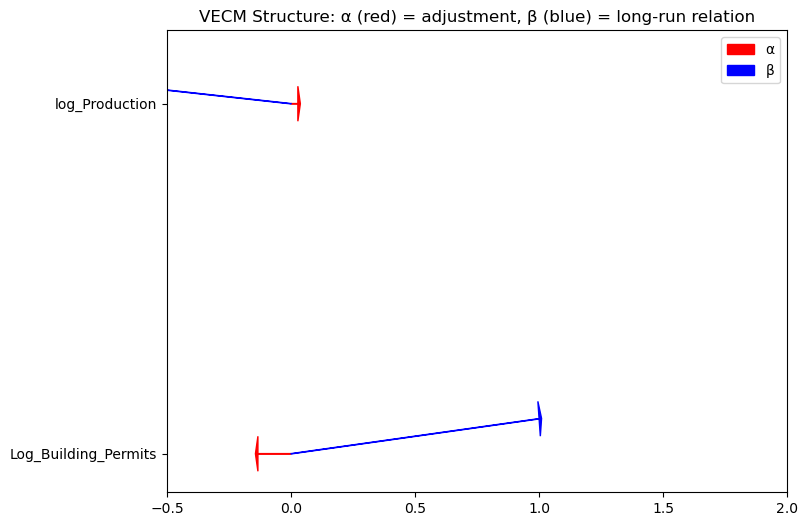

In [39]:
# Example: just showing the structure of VECM
variables = ['Log_Building_Permits', 'log_Production']
lags = 4

# α coefficients
alpha = np.array([-0.1338, 0.0273])

# β coefficients (normalized)
beta = np.array([[1.0, -1.2874]])

# Short-run lagged coefficients matrix (simplified)
# Rows: equations, Columns: lagged variables (flattened)
lagged_coeffs = np.array([
    [-0.4086, -0.2797, -0.3326, -0.0723, -0.0761, 0.0926, 0.3107, 0.2685],  # Log_Building_Permits
    [-0.0240, -0.2442, -0.0323, -0.1119, 0.0166, 0.0163, -0.0014, 0.0946]   # log_Production
])

fig, ax = plt.subplots(figsize=(8, 6))

# Plot α arrows (adjustment to equilibrium)
for i, var in enumerate(variables):
    ax.arrow(0, i, alpha[i], 0, head_width=0.1, head_length=0.01, color='red', label='α' if i==0 else "")

# Plot β arrows (long-run cointegration)
for j, var in enumerate(variables):
    ax.arrow(0, j, beta[0,j], 0.1, head_width=0.1, head_length=0.01, color='blue', label='β' if j==0 else "")

ax.set_yticks(range(len(variables)))
ax.set_yticklabels(variables)
ax.set_xlim(-0.5, 2)
ax.set_title('VECM Structure: α (red) = adjustment, β (blue) = long-run relation')
ax.legend()
plt.show()

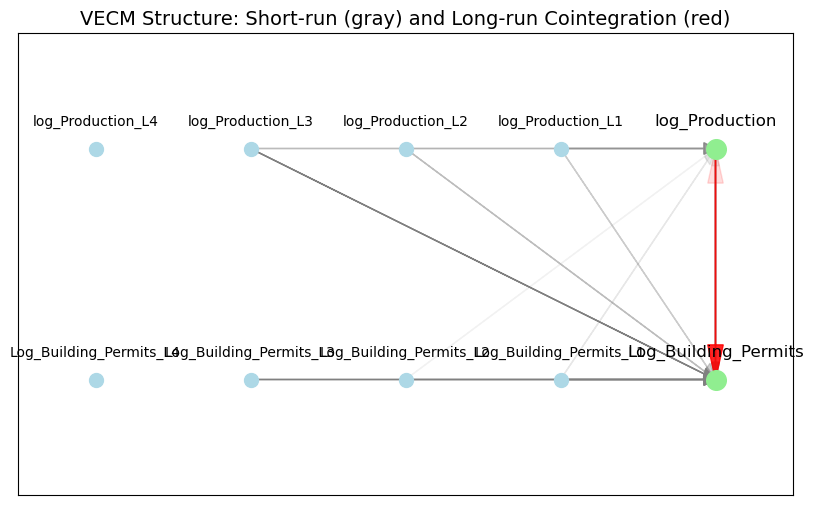

In [40]:
# Variables and lags
variables = ['Log_Building_Permits', 'log_Production']
lags = 4

# Short-run coefficients (flattened per lag: [L1_var1, L1_var2, L2_var1, ...])
lagged_coeffs = np.array([
    [-0.4086, -0.2797, -0.3326, -0.0723, -0.0761, 0.0926, 0.3107, 0.2685],  # Log_Building_Permits
    [-0.0240, -0.2442, -0.0323, -0.1119, 0.0166, 0.0163, -0.0014, 0.0946]   # log_Production
])

# Loading coefficients (α)
alpha = np.array([-0.1338, 0.0273])

# Cointegration coefficients (β)
beta = np.array([1.0, -1.2874])
const = -5.8602

fig, ax = plt.subplots(figsize=(10, 6))

# Plot current variables
for i, var in enumerate(variables):
    ax.scatter(4, i, s=200, color='lightgreen', zorder=5)
    ax.text(4, i+0.1, var, ha='center', fontsize=12)

# Plot lagged variables
for lag in range(1, lags+1):
    for i, var in enumerate(variables):
        ax.scatter(lags-lag, i, s=100, color='lightblue', zorder=5)
        ax.text(lags-lag, i+0.1, f'{var}_L{lag}', ha='center', fontsize=10)

# Draw arrows for short-run effects (lagged coefficients)
for eq_idx in range(len(variables)):
    for lag in range(lags):
        for var_idx in range(len(variables)):
            coef_idx = lag*len(variables) + var_idx
            coef = lagged_coeffs[eq_idx, coef_idx]
            if abs(coef) > 0.01:  # filter very small
                start = (lags-lag, var_idx)
                end = (4, eq_idx)
                ax.arrow(start[0], start[1], end[0]-start[0], end[1]-start[1],
                         head_width=0.05, length_includes_head=True,
                         alpha=min(abs(coef)*5,1), color='gray')

# Draw arrows for long-run cointegration (α * β)
for eq_idx in range(len(variables)):
    lr_effect = alpha[eq_idx] * beta
    for var_idx, effect in enumerate(lr_effect):
        ax.arrow(4, var_idx, 0, eq_idx-var_idx, head_width=0.1, length_includes_head=True,
                 color='red', alpha=min(abs(effect)*5, 1))

ax.set_xlim(-0.5, 4.5)
ax.set_ylim(-0.5, len(variables)-0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('VECM Structure: Short-run (gray) and Long-run Cointegration (red)', fontsize=14)
plt.show()

In [41]:
infl_q = df_quarterly1['Inflation']
endog_levels = aligned[['Log_Building_Permits', 'log_Production']]
exog_I0 = aligned[['Unemp_Gap_2sided', 'CLI', 'GDP_Growth', 'Diff_of_Log_Building_Permits_Gap']]

In [42]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import VECM
from pandas.tseries.offsets import QuarterEnd

def build_X_for_horizon(y_tr, X_tr, Zhat_h, p_lags=4):
    """Construct a single-row DataFrame for prediction at horizon h.
    
    Args:
        y_tr: inflation training series (up to time t-1)
        X_tr: exogenous training data (up to time t-1) 
        Zhat_h: VECM forecast for Z at horizon h
        p_lags: number of inflation lags
    """
    # Get the most recent values from training data
    # Inflation lags: pi_{t-1}, pi_{t-2}, ..., pi_{t-p_lags}
    cols = {}
    for L in range(p_lags):
        if len(y_tr) > L:
            cols[f"pi_lag{L+1}"] = y_tr.iloc[-(L+1)]
        else:
            cols[f"pi_lag{L+1}"] = np.nan

    # Most recent exogenous variables
    if len(X_tr) > 0:
        X_t = X_tr.iloc[-1]
        row = {**cols, **dict(zip(X_tr.columns, X_t.values))}
    else:
        row = {**cols, **{col: np.nan for col in X_tr.columns}}

    # VECM forecasts Zhat_{t+h|t}
    Z_values = Zhat_h.values[0]
    row.update({f"Z_{c}": Z_values[i] for i, c in enumerate(Zhat_h.columns)})

    # Build DataFrame row
    X_row = pd.DataFrame([row], index=[y_tr.index[-1] if len(y_tr) > 0 else pd.Timestamp('2000-01-01')])
    return X_row

def rolling_vecm_pools_forecasts(infl_q, endog_levels, exog_I0,
                                 horizons=[1,2,4], 
                                 start_train="1995-06-30",
                                 oos_start="2010-03-31",
                                 oos_end="2023-12-31",
                                 k_ar_diff=4,
                                 coint_rank=1,
                                 deterministic="ci",
                                 p_infl=4):
    """Compute rolling multi-horizon forecasts using VECM + pooled OLS."""
    # Align all inputs
    df_all = pd.concat([infl_q.rename("infl"), endog_levels, exog_I0], axis=1).dropna()
    df_all = df_all.loc[df_all.index >= pd.to_datetime(start_train)]
    
    y_name = "infl"
    Z_names = list(endog_levels.columns)
    X_names = list(exog_I0.columns)

    forecasts = {h: pd.Series(dtype=float) for h in horizons}
    oos_dates = df_all.loc[oos_start:oos_end].index

    for t_idx in oos_dates:
        # Training data up to t-1
        train = df_all.loc[:t_idx].iloc[:-1]
        y_tr = train[y_name]
        Z_tr = train[Z_names]
        X_tr = train[X_names]

        # Fit VECM
        vecm = VECM(endog=Z_tr, exog=X_tr, k_ar_diff=k_ar_diff, 
                    coint_rank=coint_rank, deterministic=deterministic)
        vecm_res = vecm.fit()

        steps = max(horizons)
        # Build naive exog forecast path (repeat last observed)
        exog_fc = np.repeat(X_tr.iloc[-1:].values, steps, axis=0)

        # Multi-step VECM forecast of Z
        Zhat_path = vecm_res.predict(steps=steps, exog_fc=exog_fc)
        Zhat_path = pd.DataFrame(Zhat_path, 
                                 index=pd.date_range(start=t_idx + QuarterEnd(), periods=steps, freq='QE'),
                                 columns=Z_names)

        # Direct regression for each horizon
        for h in horizons:
            y_h = y_tr.shift(-h)
            Z_future_h = Z_tr.shift(-h)
            X_infl_lags = pd.concat([y_tr.shift(L) for L in range(p_infl)], axis=1)
            X_infl_lags.columns = [f"pi_lag{L+1}" for L in range(p_infl)]

            X_h_train = pd.concat([X_infl_lags, X_tr, Z_future_h.add_prefix("Z_")], axis=1).dropna()
            y_h_train = y_h.loc[X_h_train.index]

            if len(y_h_train) < 10:  # Need minimum observations
                continue

            # Add constant to training data to match prediction data
            X_h_train_const = sm.add_constant(X_h_train, has_constant='add')
            ols_h = sm.OLS(y_h_train, X_h_train_const).fit()

            # Build predictor row at t using VECM forecast
            Zhat_h = Zhat_path.iloc[h-1:h]
            X_row = build_X_for_horizon(y_tr=y_tr, X_tr=X_tr, Zhat_h=Zhat_h, p_lags=p_infl)
            
            # Add constant to prediction data to match training data
            X_row_const = sm.add_constant(X_row, has_constant='add')
            
            # Ensure column order matches
            X_row_const = X_row_const[X_h_train_const.columns]
            
            # Check for NaN values
            if X_row_const.isna().any().any():
                continue
            
            # Predict
            y_hat = float(ols_h.predict(X_row_const).iloc[0])

            # Target date for forecast
            target_date = t_idx + QuarterEnd(n=h)
            forecasts[h].loc[target_date] = y_hat

    # Concatenate all horizons
    fc_df = pd.concat({h: s for h, s in forecasts.items()}, axis=1)
    fc_df.columns = [f"h{h}" for h in fc_df.columns]
    return fc_df

In [43]:
fc_df = rolling_vecm_pools_forecasts(
    infl_q=infl_q,
    endog_levels=endog_levels,
    exog_I0=exog_I0,
    horizons=[1,2,4],
    start_train="1995-06-30",
    oos_start="2010-03-31",
    oos_end="2023-12-31",
    k_ar_diff=4,
    coint_rank=1,
    deterministic="ci",
    p_infl=4
)
print(fc_df.head())
print(fc_df.tail())

                  h1        h2        h4
2010-06-30  0.000483       NaN       NaN
2010-09-30  0.008669  0.009968       NaN
2010-12-31  0.004901  0.005827       NaN
2011-03-31  0.005958  0.005445  0.006135
2011-06-30  0.003172  0.002585  0.004114
                  h1        h2        h4
2023-06-30  0.014384  0.009900  0.002826
2023-09-30  0.028802  0.025453  0.017496
2023-12-31       NaN  0.005567  0.000068
2024-03-31       NaN       NaN  0.012411
2024-06-30       NaN       NaN -0.004447


In [44]:
#Building Benchmarks (AR(1)/AR(p))
def rolling_ar_forecasts(y, horizons=[1,2,4], p=1, start="2010-03-31", end="2023-12-31"):
    forecasts = {h: pd.Series(dtype=float) for h in horizons}
    oos_dates = y.loc[start:end].index

    for t_idx in oos_dates:
        train = y.loc[:t_idx].iloc[:-1]
        if len(train) < p+1: 
            continue
        model = AutoReg(train, lags=p, old_names=False).fit()
        preds = model.predict(start=len(train), end=len(train)+max(horizons)-1)
        for h in horizons:
            target_date = t_idx + QuarterEnd(n=h)
            forecasts[h].loc[target_date] = preds.iloc[h-1]
    return pd.concat(forecasts, axis=1)

fc_ar = rolling_ar_forecasts(infl_q, horizons=[1,2,4])

In [45]:
#S&W's strong benchmark --> Integrated MA with rolling estimation
def rolling_ima_forecasts(y, horizons=[1,2,4], start="2010-03-31", end="2023-12-31"):
    forecasts = {h: pd.Series(dtype=float) for h in horizons}
    oos_dates = y.loc[start:end].index

    for t_idx in oos_dates:
        train = y.loc[:t_idx].iloc[:-1]
        try:
            model = ARIMA(train, order=(0,1,1)).fit()
            preds = model.forecast(steps=max(horizons))
            for h in horizons:
                target_date = t_idx + QuarterEnd(n=h)
                forecasts[h].loc[target_date] = preds.iloc[h-1]
        except:
            continue
    return pd.concat(forecasts, axis=1)

fc_ima = rolling_ima_forecasts(infl_q, horizons=[1,2,4])

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
common_idx = fc_df.index.intersection(infl_q.index)
actual = infl_q.loc[common_idx]
fc_df = fc_df.loc[common_idx]

In [47]:
#Computing forecast errors
errors_vecm = fc_df.subtract(actual,axis=0)
errors_ima = fc_ima.subtract(actual,axis=0)
errors_ar = fc_ar.subtract(actual,axis=0)

In [48]:
#Compare error magnitudes (RMSE/MAE)
def compute_rmse_mae(errors_df):
    stats = {}
    for h in errors_df.columns:  # h1, h2, h4
        e = errors_df[h].dropna()
        rmse = np.sqrt(np.mean(e**2))
        mae = np.mean(np.abs(e))
        stats[h] = {"RMSE": rmse, "MAE": mae}
    return pd.DataFrame(stats).T

vecm_stats = compute_rmse_mae(errors_vecm)
ima_stats  = compute_rmse_mae(errors_ima)
ar_stats   = compute_rmse_mae(errors_ar)

In [49]:
print(vecm_stats)
print(ima_stats)
print(ar_stats)

        RMSE       MAE
h1  0.008635  0.006348
h2  0.008646  0.006384
h4  0.008102  0.006064
       RMSE       MAE
1  0.006313  0.004498
2  0.007160  0.005043
4  0.008142  0.005743
       RMSE       MAE
1  0.005874  0.004636
2  0.007875  0.006314
4  0.008977  0.007716


In [50]:
common_idx = errors_vecm.index.intersection(errors_ima.index)
errors_vecm = errors_vecm.loc[common_idx]
errors_ima  = errors_ima.loc[common_idx]

common_idx = errors_ar.index.intersection(errors_ima.index)
errors_ar  = errors_ar.loc[common_idx]
errors_ima = errors_ima.loc[common_idx]

In [51]:
#Compare Relative MSFE
def relative_msfe(errors_model, errors_bench):
    rel = {}
    horizons = errors_model.columns.intersection(errors_bench.columns)
    for h in horizons:
        e_m = errors_model[h].dropna()
        e_b = errors_bench[h].dropna()
        common_idx = e_m.index.intersection(e_b.index)
        if len(common_idx) == 0:
            continue
        mse_m = np.mean(e_m.loc[common_idx]**2)
        mse_b = np.mean(e_b.loc[common_idx]**2)
        rel[h] = mse_m / mse_b
    return pd.Series(rel)

In [52]:
# Check the comparison of VECM to AR and IMA like S&W 2007
if errors_vecm.columns.dtype == object:
    errors_vecm.columns = errors_vecm.columns.str.extract('(\d+)')[0].astype(int)

if errors_ar.columns.dtype == object:
    errors_ar.columns = errors_ar.columns.str.extract('(\d+)')[0].astype(int)

# errors_ima columns are already ints

rel_vecm = relative_msfe(errors_vecm, errors_ima)
rel_ar   = relative_msfe(errors_ar, errors_ima)

print("VECM vs IMA:\n", rel_vecm)
print("AR vs IMA:\n", rel_ar)

VECM vs IMA:
 1    2.035035
2    1.457817
4    0.990030
dtype: float64
AR vs IMA:
 1    0.865899
2    1.209559
4    1.215420
dtype: float64


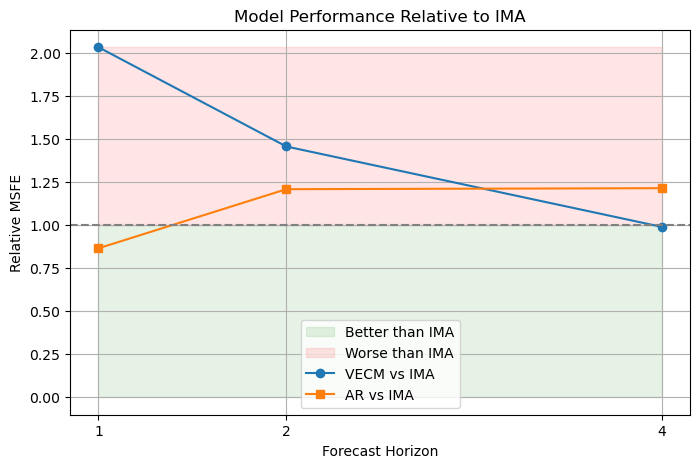

In [53]:
horizons = rel_vecm.index

plt.figure(figsize=(8,5))

# Shaded regions
plt.fill_between(horizons, 0, 1, color='green', alpha=0.1, label='Better than IMA')
plt.fill_between(horizons, 1, np.max([rel_vecm.max(), rel_ar.max()]), color='red', alpha=0.1, label='Worse than IMA')

# Plot relative MSFE
plt.plot(horizons, rel_vecm.values, marker='o', label='VECM vs IMA')
plt.plot(horizons, rel_ar.values, marker='s', label='AR vs IMA')

# Benchmark line
plt.axhline(1, color='gray', linestyle='--')

plt.xticks(horizons)
plt.xlabel('Forecast Horizon')
plt.ylabel('Relative MSFE')
plt.title('Model Performance Relative to IMA')
plt.legend()
plt.grid(True)
plt.show()

# ML Models

In [54]:
def _build_feature_frame(y, X, p_lags=4):
    """Features at time t: [pi_{t-1},...,pi_{t-p}] + X_t (contemporaneous).
    Returns DataFrame aligned to y.index, with NaNs for initial lag burn-in."""
    lag_cols = {}
    for L in range(1, p_lags+1):
        lag_cols[f"pi_lag{L}"] = y.shift(L)
    Pi = pd.DataFrame(lag_cols)
    feats = pd.concat([Pi, X], axis=1)
    return feats

In [55]:
def _make_direct_targets(y, h):
    """Target y_{t+h} aligned to time t (i.e., y shifted -h)."""
    return y.shift(-h)

In [56]:
def _forward_chaining_folds(n_obs, n_folds=5, min_train=40):
    """
    Yield (train_idx, val_idx) for forward-chaining CV.
    Training expands, validation is contiguous and never empty.
    """
    if n_obs < (min_train + n_folds):
        yield (np.arange(min_train), np.arange(min_train, n_obs))
        return

    fold_size = max(1, (n_obs - min_train) // n_folds)
    for i in range(n_folds):
        start_val = min_train + i * fold_size
        end_val = min(start_val + fold_size, n_obs)
        if start_val >= end_val:
            continue
        train_idx = np.arange(0, start_val)
        val_idx = np.arange(start_val, end_val)
        yield (train_idx, val_idx)

In [57]:
def _select_params_timecv(model_builder, Xtr, ytr, param_grid, use_scaler=False, use_pca=False, n_factors=None,
                          n_folds=5, min_train=40):
    n_obs = len(ytr)
    best_params = None
    best_score = np.inf

    Xtr_np = Xtr.values
    ytr_np = ytr.values

    for params in ParameterGrid(param_grid):
        est = model_builder(params)

        steps = []
        if use_scaler:
            steps.append(("scaler", StandardScaler()))
        if use_pca and (n_factors is not None):
            steps.append(("pca", PCA(n_components=n_factors)))
        steps.append(("model", est))
        pipe = Pipeline(steps)

        fold_mse = []
        for tr_idx, val_idx in _forward_chaining_folds(n_obs, n_folds=n_folds, min_train=min_train):
            if len(tr_idx) == 0 or len(val_idx) == 0:
                continue
            X_tr, y_tr = Xtr_np[tr_idx], ytr_np[tr_idx]
            X_val, y_val = Xtr_np[val_idx], ytr_np[val_idx]
            if len(X_val) == 0 or len(X_tr) == 0:
                continue
            pipe.fit(X_tr, y_tr)
            y_hat = pipe.predict(X_val)
            if len(y_hat) > 0:
                fold_mse.append(mean_squared_error(y_val, y_hat))

        avg_mse = np.mean(fold_mse) if fold_mse else np.inf
        if avg_mse < best_score:
            best_score = avg_mse
            best_params = params

    # --- FIX: fallback if no params were valid ---
    if best_params is None:
        print("⚠️ Warning: no valid CV folds, defaulting to first param_grid entry.")
        best_params = list(ParameterGrid(param_grid))[0]
        best_score = np.inf

    # Rebuild final pipeline
    est = model_builder(best_params)
    steps = []
    if use_scaler:
        steps.append(("scaler", StandardScaler()))
    if use_pca and (n_factors is not None):
        steps.append(("pca", PCA(n_components=n_factors)))
    steps.append(("model", est))
    return Pipeline(steps), best_params, best_score

In [58]:
def _rolling_ml_direct(y, X, horizons=(1,2,4),
                       start_train="1995-06-30",
                       oos_start="2010-03-31",
                       oos_end="2023-12-31",
                       p_lags=4,
                       window_type="expanding",    # "expanding" or "rolling"
                       rolling_window=None,        # required if window_type="rolling"
                       use_pca=False, n_factors=None,
                       model_builder=None, param_grid=None,
                       use_scaler=False,
                       cv_folds=5, min_train=40, random_state=123):
    """
    Generic rolling-direct-forecast engine used by the four wrappers below.
    - model_builder(params) -> sklearn estimator
    - param_grid: dict for ParameterGrid
    """
    # Align and trim
    df = pd.concat([y.rename("infl"), X], axis=1).dropna()
    df = df.loc[df.index >= pd.to_datetime(start_train)].copy()

    feats = _build_feature_frame(df["infl"], df.drop(columns=["infl"]), p_lags=p_lags)

    # OOS origins: match your design (use t as origin, forecast y_{t+h})
    oos_dates = df.loc[oos_start:oos_end].index

    forecasts = {h: pd.Series(dtype=float) for h in horizons}

    for t_idx in oos_dates:
        # Training set up to t-1
        tr_end_pos = df.index.get_loc(t_idx)  # position of t in df
        # Build target-per-h DataFrames once per t
        # For training matrices, we only include rows with non-missing y_{t+h} (within sample)
        # Apply windowing
        if window_type == "expanding":
            tr_slice = slice(0, tr_end_pos)  # [0, t-1]
        elif window_type == "rolling":
            if rolling_window is None:
                raise ValueError("Provide rolling_window when window_type='rolling'.")
            tr_start_pos = max(0, tr_end_pos - rolling_window)
            tr_slice = slice(tr_start_pos, tr_end_pos)
        else:
            raise ValueError("window_type must be 'expanding' or 'rolling'.")

        # Minimum training length guard
        if (tr_end_pos - (tr_slice.start or 0)) < max(min_train, p_lags+6):
            continue

        # We'll tune per horizon, as in direct forecasting setups
        for h in horizons:
            # Build training design/target for this horizon
            y_h = _make_direct_targets(df["infl"], h)
            # Align X (features at time t)
            X_h = feats

            # Training data indices (drop rows with NaN in X or y_h)
            Tr = pd.concat([X_h.iloc[tr_slice], y_h.iloc[tr_slice]], axis=1).dropna()
            if Tr.empty or len(Tr) < min_train:
                continue

            X_tr = Tr.iloc[:, :-1]
            y_tr = Tr.iloc[:, -1]

            # Time-series CV to select params
            pipe, best_params, best_cv_mse = _select_params_timecv(
                model_builder, X_tr, y_tr,
                param_grid=param_grid,
                use_scaler=use_scaler,
                use_pca=use_pca,
                n_factors=n_factors,
                n_folds=cv_folds,
                min_train=min_train
            )

            # Refit on full training data
            pipe.fit(X_tr.values, y_tr.values)

            # Build feature row at origin t (using info available at t)
            x_row = feats.loc[[t_idx]].dropna()
            if x_row.empty:
                continue

            y_hat = float(pipe.predict(x_row.values)[0])
            target_date = t_idx + QuarterEnd(n=h)
            forecasts[h].loc[target_date] = y_hat

    fc_df = pd.concat({h: s for h, s in forecasts.items()}, axis=1)
    fc_df.columns = [f"h{h}" for h in fc_df.columns]
    return fc_df

In [59]:
#1) RANDOM FOREST (nonlinear, no scaling needed)
def rolling_rf_forecasts(y, X, horizons=(1,2,4),
                         start_train="1995-06-30",
                         oos_start="2010-03-31",
                         oos_end="2023-12-31",
                         p_lags=4,
                         window_type="expanding",
                         rolling_window=None,
                         use_pca=False, n_factors=None,
                         cv_folds=5, min_train=40, random_state=123):
    def build_rf(params):
        return RandomForestRegressor(
            n_estimators=params.get("n_estimators", 500),
            max_depth=params.get("max_depth", None),
            min_samples_split=params.get("min_samples_split", 2),
            min_samples_leaf=params.get("min_samples_leaf", 1),
            max_features=params.get("max_features", "sqrt"),
            random_state=random_state,
            n_jobs=-1
        )
    param_grid = {
    "n_estimators": [400],     # fewer trees
    "max_depth": [6, None],    # limit grid
    "max_features": ["sqrt"]   # drop log2
    }

    return _rolling_ml_direct(
        y, X, horizons,
        start_train, oos_start, oos_end,
        p_lags,
        window_type, rolling_window,
        use_pca, n_factors,
        model_builder=build_rf, param_grid=param_grid,
        use_scaler=False,
        cv_folds=cv_folds, min_train=min_train, random_state=random_state
    )

In [60]:
#2) XGBOOST (nonlinear boosting)
def rolling_xgb_fast(y, X, horizons=(1,2,4),
                     start_train="1995-06-30",
                     oos_start="2010-03-31",
                     oos_end="2023-12-31",
                     p_lags=4,
                     window_type="expanding",
                     rolling_window=None,
                     use_pca=False, n_factors=None,
                     min_train=60,
                     random_state=42):
    """
    Fast rolling direct forecasts with XGBoost (fixed params, no CV).
    """

    # Fixed params (reasonable defaults for macro time series)
    fixed_params = dict(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        reg_lambda=1.0,
        objective="reg:squarederror",
        random_state=random_state,
        n_jobs=-1
    )

    # Align data
    df = pd.concat([y.rename("infl"), X], axis=1).dropna()
    df = df.loc[df.index >= pd.to_datetime(start_train)].copy()

    # Build inflation lags
    lag_cols = {}
    for L in range(1, p_lags+1):
        lag_cols[f"pi_lag{L}"] = df["infl"].shift(L)
    feats = pd.concat([pd.DataFrame(lag_cols, index=df.index), df.drop(columns=["infl"])], axis=1)

    oos_dates = df.loc[oos_start:oos_end].index
    forecasts = {h: pd.Series(dtype=float) for h in horizons}

    for t_idx in oos_dates:
        tr_end_pos = df.index.get_loc(t_idx)

        if window_type == "expanding":
            tr_slice = slice(0, tr_end_pos)
        elif window_type == "rolling":
            if rolling_window is None:
                raise ValueError("Provide rolling_window when window_type='rolling'.")
            tr_start_pos = max(0, tr_end_pos - rolling_window)
            tr_slice = slice(tr_start_pos, tr_end_pos)
        else:
            raise ValueError("window_type must be 'expanding' or 'rolling'.")

        # Skip if too few obs
        if (tr_end_pos - (tr_slice.start or 0)) < min_train:
            continue

        for h in horizons:
            # Direct target y_{t+h}
            y_h = df["infl"].shift(-h)
            X_h = feats

            Tr = pd.concat([X_h.iloc[tr_slice], y_h.iloc[tr_slice]], axis=1).dropna()
            if Tr.empty or len(Tr) < min_train:
                continue

            X_tr = Tr.iloc[:, :-1]
            y_tr = Tr.iloc[:, -1]

            # Fit fixed-parameter XGBoost
            model = XGBRegressor(**fixed_params)
            model.fit(X_tr.values, y_tr.values)

            # Forecast at origin t
            x_row = feats.loc[[t_idx]].dropna()
            if x_row.empty:
                continue
            y_hat = float(model.predict(x_row.values)[0])

            target_date = t_idx + QuarterEnd(n=h)
            forecasts[h].loc[target_date] = y_hat

    fc_df = pd.concat({h: s for h, s in forecasts.items()}, axis=1)
    fc_df.columns = [f"h{h}" for h in fc_df.columns]
    return fc_df

In [61]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def rolling_svr_fast(y, X, horizons=(1,2,4),
                     start_train="1995-06-30",
                     oos_start="2010-03-31",
                     oos_end="2023-12-31",
                     p_lags=4,
                     window_type="expanding",
                     rolling_window=None,
                     min_train=60,
                     random_state=42):
    """
    Fast rolling direct forecasts with SVR (RBF kernel).
    Uses fixed sensible params (C, gamma) and scaling.
    """

    fixed_params = dict(
        kernel="rbf",
        C=10.0,         # penalty term
        gamma=0.1,      # RBF width
        epsilon=0.0     # L2-like loss (per Coulombe et al.)
    )

    df = pd.concat([y.rename("infl"), X], axis=1).dropna()
    df = df.loc[df.index >= pd.to_datetime(start_train)].copy()

    lag_cols = {}
    for L in range(1, p_lags+1):
        lag_cols[f"pi_lag{L}"] = df["infl"].shift(L)
    feats = pd.concat([pd.DataFrame(lag_cols, index=df.index), df.drop(columns=["infl"])], axis=1)

    oos_dates = df.loc[oos_start:oos_end].index
    forecasts = {h: pd.Series(dtype=float) for h in horizons}

    for t_idx in oos_dates:
        tr_end_pos = df.index.get_loc(t_idx)

        if window_type == "expanding":
            tr_slice = slice(0, tr_end_pos)
        elif window_type == "rolling":
            if rolling_window is None:
                raise ValueError("Provide rolling_window when window_type='rolling'.")
            tr_start_pos = max(0, tr_end_pos - rolling_window)
            tr_slice = slice(tr_start_pos, tr_end_pos)
        else:
            raise ValueError("window_type must be 'expanding' or 'rolling'.")

        if (tr_end_pos - (tr_slice.start or 0)) < min_train:
            continue

        for h in horizons:
            y_h = df["infl"].shift(-h)
            X_h = feats
            Tr = pd.concat([X_h.iloc[tr_slice], y_h.iloc[tr_slice]], axis=1).dropna()
            if Tr.empty or len(Tr) < min_train:
                continue

            X_tr = Tr.iloc[:, :-1]
            y_tr = Tr.iloc[:, -1]

            model = Pipeline([
                ("scaler", StandardScaler()),
                ("svr", SVR(**fixed_params))
            ])
            model.fit(X_tr.values, y_tr.values)

            x_row = feats.loc[[t_idx]].dropna()
            if x_row.empty:
                continue

            y_hat = float(model.predict(x_row.values)[0])
            target_date = t_idx + QuarterEnd(n=h)
            forecasts[h].loc[target_date] = y_hat

    fc_df = pd.concat({h: s for h, s in forecasts.items()}, axis=1)
    fc_df.columns = [f"h{h}" for h in fc_df.columns]
    return fc_df

In [62]:
from sklearn.kernel_ridge import KernelRidge

def rolling_krr_fast(y, X, horizons=(1,2,4),
                     start_train="1995-06-30",
                     oos_start="2010-03-31",
                     oos_end="2023-12-31",
                     p_lags=4,
                     window_type="expanding",
                     rolling_window=None,
                     min_train=60,
                     random_state=42):
    """
    Fast rolling direct forecasts with Kernel Ridge (RBF).
    Uses fixed sensible params (alpha, gamma) and scaling.
    """

    fixed_params = dict(
        kernel="rbf",
        alpha=1.0,   # regularization
        gamma=0.1    # RBF width
    )

    df = pd.concat([y.rename("infl"), X], axis=1).dropna()
    df = df.loc[df.index >= pd.to_datetime(start_train)].copy()

    lag_cols = {}
    for L in range(1, p_lags+1):
        lag_cols[f"pi_lag{L}"] = df["infl"].shift(L)
    feats = pd.concat([pd.DataFrame(lag_cols, index=df.index), df.drop(columns=["infl"])], axis=1)

    oos_dates = df.loc[oos_start:oos_end].index
    forecasts = {h: pd.Series(dtype=float) for h in horizons}

    for t_idx in oos_dates:
        tr_end_pos = df.index.get_loc(t_idx)

        if window_type == "expanding":
            tr_slice = slice(0, tr_end_pos)
        elif window_type == "rolling":
            if rolling_window is None:
                raise ValueError("Provide rolling_window when window_type='rolling'.")
            tr_start_pos = max(0, tr_end_pos - rolling_window)
            tr_slice = slice(tr_start_pos, tr_end_pos)
        else:
            raise ValueError("window_type must be 'expanding' or 'rolling'.")

        if (tr_end_pos - (tr_slice.start or 0)) < min_train:
            continue

        for h in horizons:
            y_h = df["infl"].shift(-h)
            X_h = feats
            Tr = pd.concat([X_h.iloc[tr_slice], y_h.iloc[tr_slice]], axis=1).dropna()
            if Tr.empty or len(Tr) < min_train:
                continue

            X_tr = Tr.iloc[:, :-1]
            y_tr = Tr.iloc[:, -1]

            model = Pipeline([
                ("scaler", StandardScaler()),
                ("krr", KernelRidge(**fixed_params))
            ])
            model.fit(X_tr.values, y_tr.values)

            x_row = feats.loc[[t_idx]].dropna()
            if x_row.empty:
                continue

            y_hat = float(model.predict(x_row.values)[0])
            target_date = t_idx + QuarterEnd(n=h)
            forecasts[h].loc[target_date] = y_hat

    fc_df = pd.concat({h: s for h, s in forecasts.items()}, axis=1)
    fc_df.columns = [f"h{h}" for h in fc_df.columns]
    return fc_df

In [63]:
# Build the ML predictor set (match Step 4: lags of inflation + activity variables)
X_pred = pd.concat([endog_levels, exog_I0], axis=1)

In [64]:
# Combine all series into a single DataFrame for ML
X_all = pd.concat([
    I1_vars[['Log_Building_Permits', 'log_Production']],  # main activity variables
    df2_q,  # Unemp_Gap_2sided
    df3_q,  # CLI
    df5_q,  # GDP_Growth
    gap_diff  # Diff_of_Log_Building_Permits_Gap
], axis=1)

# Optionally, you can drop rows with missing data to avoid ML errors
X_all = X_all.dropna()

# Check the result
print(X_all.shape)
print(X_all.head())

(113, 6)
            Log_Building_Permits  log_Production  Unemp_Gap_2sided        CLI  \
1995-06-30             11.218689        4.461173         -0.892500  99.770787   
1995-09-30             11.152673        4.475872         -0.809583  99.929557   
1995-12-31             11.227108        4.490542         -0.821667  99.915180   
1996-03-31             10.867043        4.499574         -0.780833  99.918903   
1996-06-30             10.994739        4.507698         -0.806250  99.942827   

            GDP_Growth         0  
1995-06-30    0.000282 -0.066016  
1995-09-30    0.019581  0.074436  
1995-12-31   -0.005678 -0.360065  
1996-03-31    0.011121  0.127696  
1996-06-30   -0.001034 -0.019326  


In [65]:
fc_rf  = rolling_rf_forecasts(
    infl_q, X_all, horizons=(1,2,4),
    start_train="1995-06-30",
    oos_start="2010-03-31",
    oos_end="2023-12-31",
    p_lags=4,
    window_type="expanding",
    use_pca=False, n_factors=None,
    cv_folds=2, min_train=20, random_state=42
)

In [66]:
print(type(fc_rf))
print(fc_rf.head())

<class 'pandas.core.frame.DataFrame'>
                  h1        h2        h4
2010-06-30  0.008924       NaN       NaN
2010-09-30  0.003639  0.001767       NaN
2010-12-31  0.005063  0.005468       NaN
2011-03-31  0.002691  0.003062  0.004485
2011-06-30  0.009777  0.009913  0.008221


In [67]:
# Build predictors
X_pred = pd.concat([endog_levels, exog_I0], axis=1)

# Kernel Ridge forecasts
fc_rf = rolling_rf_forecasts(infl_q, X_pred, horizons=(1,2,4))
print(fc_rf.head())
print(fc_rf.tail())

# Errors & evaluation
common_idx = infl_q.index.intersection(fc_rf.index)
actual = infl_q.loc[common_idx]
errors_rf_fast = fc_rf.loc[common_idx].subtract(actual, axis=0)

print("Random-Forest RMSE/MAE:")
print(compute_rmse_mae(errors_rf_fast))

                  h1        h2        h4
2010-06-30  0.008535       NaN       NaN
2010-09-30  0.003783  0.001923       NaN
2010-12-31  0.004977  0.005436       NaN
2011-03-31  0.002283  0.003210  0.004334
2011-06-30  0.009912  0.009648  0.008762
                  h1        h2        h4
2023-06-30  0.019205  0.018992  0.007295
2023-09-30  0.011540  0.013445  0.007833
2023-12-31       NaN  0.019250  0.016008
2024-03-31       NaN       NaN  0.010741
2024-06-30       NaN       NaN  0.014957
Random-Forest RMSE/MAE:
        RMSE       MAE
h1  0.005853  0.003835
h2  0.006432  0.004295
h4  0.007059  0.004828


In [68]:
# Combine actual inflation with forecasts
check_df = pd.concat([infl_q.rename("Inflation"), fc_rf], axis=1)

# Drop rows with missing values for evaluation
eval_df = check_df[["Inflation", "h1", "h2", "h4"]].dropna()

# Compute MSE and Bias for each horizon
for h in ["h1", "h2", "h4"]:
    mse = mean_squared_error(eval_df["Inflation"], eval_df[h])
    bias = (eval_df[h] - eval_df["Inflation"]).mean()
    print(f"{h}: MSE={mse:.6f}, Bias={bias:.6f}")

h1: MSE=0.000036, Bias=-0.001041
h2: MSE=0.000039, Bias=-0.001285
h4: MSE=0.000048, Bias=-0.001691


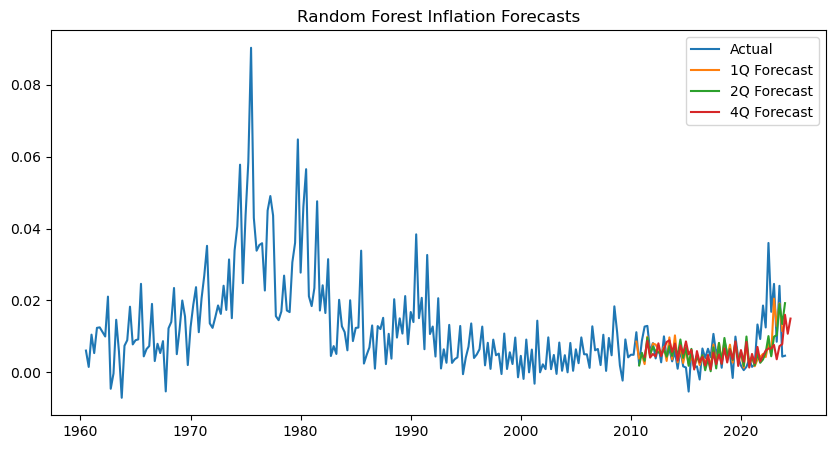

In [69]:
# Plotting Random Forest
plt.figure(figsize=(10,5))
plt.plot(infl_q, label="Actual")
plt.plot(fc_rf['h1'], label="1Q Forecast")
plt.plot(fc_rf['h2'], label="2Q Forecast")
plt.plot(fc_rf['h4'], label="4Q Forecast")
plt.legend()
plt.title("Random Forest Inflation Forecasts")
plt.show()

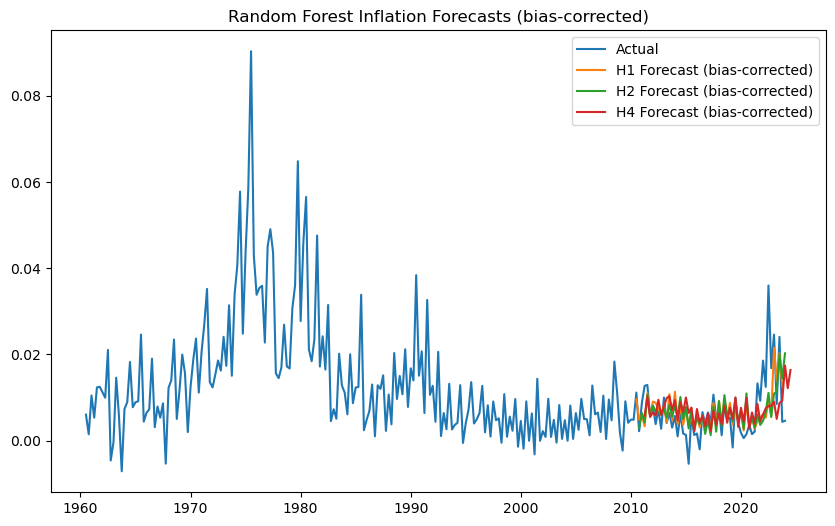

In [70]:
# Plotting Random Forest Bias Corrected
for h in ["h1", "h2", "h4"]:
    check_df[h + "_adj"] = check_df[h] - (check_df[h] - check_df["Inflation"]).mean()

plt.figure(figsize=(10,6))
plt.plot(check_df["Inflation"], label="Actual")
plt.plot(check_df["h1_adj"], label="H1 Forecast (bias-corrected)")
plt.plot(check_df["h2_adj"], label="H2 Forecast (bias-corrected)")
plt.plot(check_df["h4_adj"], label="H4 Forecast (bias-corrected)")
plt.legend()
plt.title("Random Forest Inflation Forecasts (bias-corrected)")
plt.show()

In [71]:
#XGBoost
X_pred = pd.concat([endog_levels, exog_I0], axis=1)

fc_xgb_fast = rolling_xgb_fast(
    infl_q, X_pred,
    horizons=(1,2,4),
    start_train="1995-06-30",
    oos_start="2010-03-31",
    oos_end="2023-12-31",
    p_lags=4,
    window_type="expanding",
    min_train=60,
    random_state=42
)

print(fc_xgb_fast.head())
print(fc_xgb_fast.tail())

# --- Compute forecast errors ---
common_idx = infl_q.index.intersection(fc_xgb_fast.index)
actual = infl_q.loc[common_idx]
fc_xgb_fast = fc_xgb_fast.loc[common_idx]

errors_xgb_fast = fc_xgb_fast.subtract(actual, axis=0)

# --- Align with IMA benchmark ---
errors_xgb_fast.columns = errors_xgb_fast.columns.str.extract("(\d+)")[0].astype(int)
errors_ima.columns = errors_ima.columns.astype(int)

common_idx = errors_xgb_fast.index.intersection(errors_ima.index)
errors_xgb_fast = errors_xgb_fast.loc[common_idx]
errors_ima_aligned = errors_ima.loc[common_idx]

# --- Evaluation stats ---
xgb_fast_stats = compute_rmse_mae(errors_xgb_fast)
print("XGB-fast RMSE/MAE:")
print(xgb_fast_stats)

# --- Relative MSFE vs IMA ---
rel_xgb_fast = relative_msfe(errors_xgb_fast, errors_ima_aligned)
print("XGB-fast vs IMA relative MSFE:")
print(rel_xgb_fast)

                  h1        h2        h4
2011-09-30  0.006239       NaN       NaN
2011-12-31  0.007448  0.005357       NaN
2012-03-31  0.007682  0.005365       NaN
2012-06-30  0.005224  0.004857  0.008846
2012-09-30  0.006424  0.005037  0.004275
                  h1        h2        h4
2023-06-30  0.027761  0.020881  0.007172
2023-09-30  0.011892  0.013029  0.009027
2023-12-31       NaN  0.023478  0.018280
2024-03-31       NaN       NaN  0.012769
2024-06-30       NaN       NaN  0.018715
XGB-fast RMSE/MAE:
       RMSE       MAE
1  0.006030  0.003982
2  0.006964  0.004670
4  0.007364  0.005094
XGB-fast vs IMA relative MSFE:
1    0.968730
2    0.894405
4    0.768052
dtype: float64


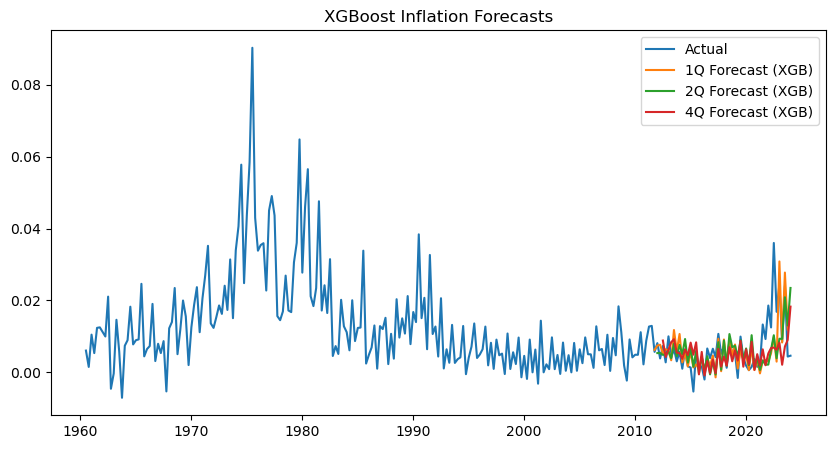

In [72]:
# Plotting XGBoost forecasts
plt.figure(figsize=(10,5))
plt.plot(infl_q, label="Actual")
plt.plot(fc_xgb_fast['h1'], label="1Q Forecast (XGB)")
plt.plot(fc_xgb_fast['h2'], label="2Q Forecast (XGB)")
plt.plot(fc_xgb_fast['h4'], label="4Q Forecast (XGB)")
plt.legend()
plt.title("XGBoost Inflation Forecasts")
plt.show()

                  h1        h2        h4
2011-09-30  0.004601       NaN       NaN
2011-12-31  0.010065  0.012384       NaN
2012-03-31  0.011134  0.007768       NaN
2012-06-30  0.003858  0.006004  0.007683
2012-09-30  0.002401  0.006819  0.005054
                  h1        h2        h4
2023-06-30  0.008402  0.008254  0.008981
2023-09-30  0.007505  0.006530  0.007557
2023-12-31       NaN  0.008042  0.009579
2024-03-31       NaN       NaN  0.007043
2024-06-30       NaN       NaN  0.007695
SVR-fast RMSE/MAE:
        RMSE       MAE
h1  0.007196  0.004565
h2  0.006703  0.004695
h4  0.006866  0.004744


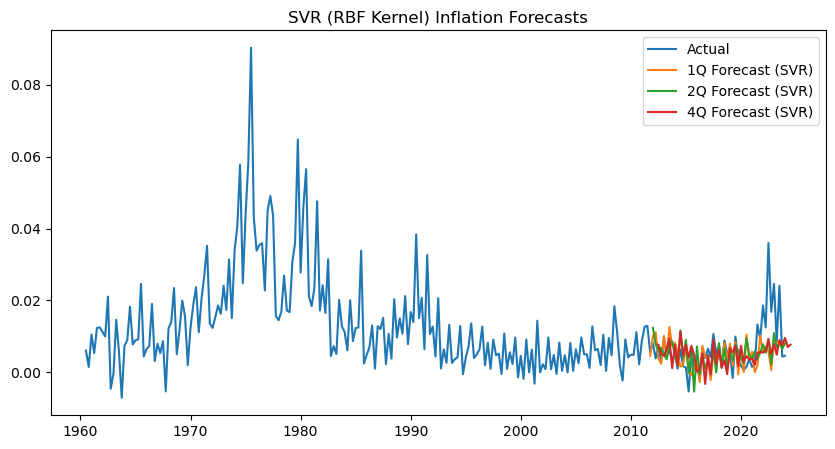

In [73]:
#SVR (RBF)
# Build predictors
X_pred = pd.concat([endog_levels, exog_I0], axis=1)

# SVR forecasts
fc_svr_fast = rolling_svr_fast(infl_q, X_pred, horizons=(1,2,4))
print(fc_svr_fast.head())
print(fc_svr_fast.tail())

# Errors & evaluation
common_idx = infl_q.index.intersection(fc_svr_fast.index)
actual = infl_q.loc[common_idx]
errors_svr_fast = fc_svr_fast.loc[common_idx].subtract(actual, axis=0)

print("SVR-fast RMSE/MAE:")
print(compute_rmse_mae(errors_svr_fast))

# Plotting SVR forecasts
plt.figure(figsize=(10,5))
plt.plot(infl_q, label="Actual")
plt.plot(fc_svr_fast['h1'], label="1Q Forecast (SVR)")
plt.plot(fc_svr_fast['h2'], label="2Q Forecast (SVR)")
plt.plot(fc_svr_fast['h4'], label="4Q Forecast (SVR)")
plt.legend()
plt.title("SVR (RBF Kernel) Inflation Forecasts")
plt.show()


                  h1        h2        h4
2011-09-30  0.003189       NaN       NaN
2011-12-31  0.005952  0.006000       NaN
2012-03-31  0.006321  0.004864       NaN
2012-06-30  0.005221  0.004977  0.004755
2012-09-30  0.003233  0.004933  0.003202
                  h1        h2        h4
2023-06-30  0.001631  0.001768  0.003503
2023-09-30  0.000744  0.000700  0.000619
2023-12-31       NaN  0.001441  0.001622
2024-03-31       NaN       NaN  0.000144
2024-06-30       NaN       NaN  0.000436
KRR-fast RMSE/MAE:
        RMSE       MAE
h1  0.007811  0.004573
h2  0.007397  0.004588
h4  0.007557  0.004935


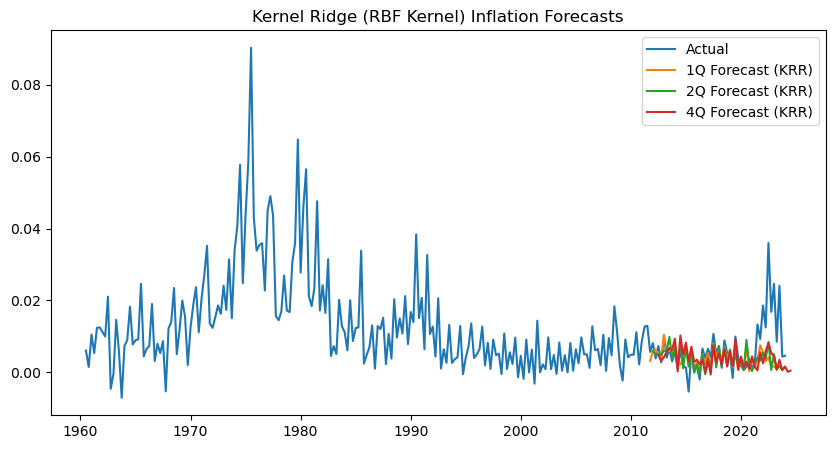

In [74]:
# ==== Kernel Ridge (RBF) ====

# Build predictors
X_pred = pd.concat([endog_levels, exog_I0], axis=1)

# Kernel Ridge forecasts
fc_krr_fast = rolling_krr_fast(infl_q, X_pred, horizons=(1,2,4))
print(fc_krr_fast.head())
print(fc_krr_fast.tail())

# Errors & evaluation
common_idx = infl_q.index.intersection(fc_krr_fast.index)
actual = infl_q.loc[common_idx]
errors_krr_fast = fc_krr_fast.loc[common_idx].subtract(actual, axis=0)

print("KRR-fast RMSE/MAE:")
print(compute_rmse_mae(errors_krr_fast))

# Plotting Kernel Ridge forecasts
plt.figure(figsize=(10,5))
plt.plot(infl_q, label="Actual")
plt.plot(fc_krr_fast['h1'], label="1Q Forecast (KRR)")
plt.plot(fc_krr_fast['h2'], label="2Q Forecast (KRR)")
plt.plot(fc_krr_fast['h4'], label="4Q Forecast (KRR)")
plt.legend()
plt.title("Kernel Ridge (RBF Kernel) Inflation Forecasts")
plt.show()

## Consolidation of Results into Comparison Tables

In [75]:
# if IMA has "h1","h2","h4", rename to integers
rename_dict = {"h1": 1, "h2": 2, "h4": 4}

errors_ima_aligned = errors_ima_aligned.rename(columns=rename_dict)
errors_rf_fast = errors_rf_fast.rename(columns=rename_dict)
errors_xgb_fast = errors_xgb_fast.rename(columns=rename_dict)
errors_svr_fast = errors_svr_fast.rename(columns=rename_dict)
errors_krr_fast = errors_krr_fast.rename(columns=rename_dict)

def compute_stats(errors, errors_benchmark):
    """
    Compute RMSE, MAE and relative MSFE vs benchmark.
    errors: DataFrame [T x H]
    errors_benchmark: DataFrame [T x H] (aligned to same horizons)
    """
    stats = {}
    for h in errors.columns:
        e = errors[h].dropna()
        b = errors_benchmark[h].dropna()
        common_idx = e.index.intersection(b.index)
        e, b = e.loc[common_idx], b.loc[common_idx]

        rmse = np.sqrt(mean_squared_error(np.zeros(len(e)), e))
        mae = mean_absolute_error(np.zeros(len(e)), e)
        rel_msfe = np.mean(e**2) / np.mean(b**2)

        stats[h] = {"RMSE": rmse, "MAE": mae, "Rel_MSFE": rel_msfe}
    
    return pd.DataFrame(stats).T

# Run for all models
rf_stats = compute_stats(errors_rf_fast, errors_ima_aligned)
xgb_stats = compute_stats(errors_xgb_fast, errors_ima_aligned)
svr_stats = compute_stats(errors_svr_fast, errors_ima_aligned)
krr_stats = compute_stats(errors_krr_fast, errors_ima_aligned)

# Combine into one comparison table
comparison_table = pd.concat(
    {"RF": rf_stats, "XGB": xgb_stats, "SVR": svr_stats, "KRR": krr_stats},
    axis=0
)
print(comparison_table)

           RMSE       MAE  Rel_MSFE
RF  1  0.005903  0.003787  0.928246
    2  0.006513  0.004309  0.798151
    4  0.007076  0.004770  0.751062
XGB 1  0.006030  0.003982  0.968730
    2  0.006964  0.004670  0.894405
    4  0.007364  0.005094  0.768052
SVR 1  0.007196  0.004565  1.379447
    2  0.006703  0.004695  0.828504
    4  0.006866  0.004744  0.667647
KRR 1  0.007811  0.004573  1.625455
    2  0.007397  0.004588  1.009129
    4  0.007557  0.004935  0.808890


In [78]:
def robustness_check(errors_dict, benchmark):
    """
    errors_dict: {model_name: error_df}
    benchmark: DataFrame with benchmark errors
    """
    results = {}
    for name, errs in errors_dict.items():
        stats = compute_stats(errs, benchmark)
        results[name] = stats
    
    # Combine into single table
    comp_table = pd.concat(results, axis=0)
    
    # Sort by horizon
    comp_table = comp_table.sort_index(level=1)
    
    return comp_table

errors_dict = {
    "RF": errors_rf_fast,
    "XGB": errors_xgb_fast,
    "SVR": errors_svr_fast,
    "KRR": errors_krr_fast,
}

comparison_table = robustness_check(errors_dict, errors_ima_aligned)
print(comparison_table)

           RMSE       MAE  Rel_MSFE
KRR 1  0.007811  0.004573  1.625455
RF  1  0.005903  0.003787  0.928246
SVR 1  0.007196  0.004565  1.379447
XGB 1  0.006030  0.003982  0.968730
KRR 2  0.007397  0.004588  1.009129
RF  2  0.006513  0.004309  0.798151
SVR 2  0.006703  0.004695  0.828504
XGB 2  0.006964  0.004670  0.894405
KRR 4  0.007557  0.004935  0.808890
RF  4  0.007076  0.004770  0.751062
SVR 4  0.006866  0.004744  0.667647
XGB 4  0.007364  0.005094  0.768052


## Getting Everything In Line

In [101]:
# Required imports
import numpy as np
import pandas as pd
from itertools import combinations
from pandas.tseries.offsets import QuarterEnd

from statsmodels.tsa.vector_ar.vecm import VECM
from sklearn.linear_model import Ridge

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor


# ============ SCORING + WEIGHTING (Steel, 2012) ============
def gaussian_log_score(y_true, y_pred):
    e = y_true - y_pred
    sigma2 = np.mean(e**2) + 1e-8
    return -0.5 * (np.log(2*np.pi*sigma2) + (e**2)/sigma2)

def aggregate_log_score(y_true, y_pred):
    return float(np.sum(gaussian_log_score(np.asarray(y_true), np.asarray(y_pred))))

def steel_weights_from_logscores(logscores, occam_ratio=0.05, prior=None, temperature=1.0):
    if not logscores:
        return {}
    if prior is None:
        prior = {k: 0.0 for k in logscores}
    adj = {k: logscores[k] + prior.get(k, 0.0) for k in logscores}
    m = max(adj.values())
    raw = {k: np.exp((adj[k] - m) / max(1e-8, temperature)) for k in adj}
    max_w = max(raw.values())
    kept = {k: v for k, v in raw.items() if v >= occam_ratio * max_w}
    Z = sum(kept.values())
    if Z <= 0:
        uni = 1.0 / len(raw)
        return {k: uni for k in raw}
    return {k: v / Z for k, v in kept.items()}

def _safe_weighted_mean(values_dict, weights_dict):
    kept = [(k, values_dict[k], weights_dict.get(k, 0.0)) for k in values_dict if k in weights_dict and np.isfinite(values_dict[k])]
    if kept:
        num = sum(v * w for _, v, w in kept)
        den = sum(w for _, _, w in kept)
        if den > 0:
            return num / den
    vals = [v for v in values_dict.values() if np.isfinite(v)]
    return float(np.mean(vals)) if vals else np.nan


# ============ UTILITY FUNCTIONS ============
def build_feature_frame(y, X, p_lags=4):
    lag_cols = {}
    for L in range(1, p_lags+1):
        lag_cols[f"pi_lag{L}"] = y.shift(L)
    Pi = pd.DataFrame(lag_cols)
    feats = pd.concat([Pi, X], axis=1)
    return feats

def make_direct_targets(y, h):
    return y.shift(-h)

def forward_chaining_folds(n_obs, n_folds=5, min_train=40):
    if n_obs < (min_train + n_folds):
        yield (np.arange(min_train), np.arange(min_train, n_obs))
        return
    fold_size = max(1, (n_obs - min_train) // n_folds)
    for i in range(n_folds):
        start_val = min_train + i * fold_size
        end_val = min(start_val + fold_size, n_obs)
        if start_val >= end_val:
            continue
        train_idx = np.arange(0, start_val)
        val_idx = np.arange(start_val, end_val)
        yield (train_idx, val_idx)


# ============ SPECIFICATION GENERATORS ============
def generate_vecm_specifications():
    specs = []
    k_ar_options = [2, 3, 4]
    coint_rank_options = [1, 2]
    deterministic_options = ['ci', 'cili']
    base_exog = ['Unemp_Gap_2sided', 'CLI', 'GDP_Growth', 'Diff_of_Log_Building_Permits_Gap']

    exog_combinations = []
    for r in range(1, min(4, len(base_exog) + 1)):
        for combo in combinations(base_exog, r):
            exog_combinations.append(list(combo))

    for k_ar in k_ar_options:
        for coint_rank in coint_rank_options:
            for deterministic in deterministic_options:
                for exog_vars in exog_combinations[:6]:
                    specs.append({
                        'k_ar_diff': k_ar,
                        'coint_rank': coint_rank,
                        'deterministic': deterministic,
                        'exog_vars': exog_vars,
                        'id': f"VECM_k{k_ar}_r{coint_rank}_{deterministic}_ex{len(exog_vars)}"
                    })
    return specs

def generate_ml_configurations():
    configs = []

    rf_configs = [
        {'model': 'RF', 'n_estimators': 400, 'max_depth': 6, 'max_features': 'sqrt'},
        {'model': 'RF', 'n_estimators': 500, 'max_depth': None, 'max_features': 'sqrt'}
    ]

    xgb_configs = [
        {'model': 'XGB', 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8},
        {'model': 'XGB', 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
    ]

    svr_configs = [
        {'model': 'SVR', 'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf', 'epsilon': 0.0},
        {'model': 'SVR', 'C': 1.0, 'gamma': 0.05, 'kernel': 'rbf', 'epsilon': 0.01}
    ]

    krr_configs = [
        {'model': 'KRR', 'alpha': 1.0, 'gamma': 0.1, 'kernel': 'rbf'},
        {'model': 'KRR', 'alpha': 0.1, 'gamma': 0.05, 'kernel': 'rbf'}
    ]

    configs.extend(rf_configs + xgb_configs + svr_configs + krr_configs)
    for i, config in enumerate(configs):
        config['id'] = f"{config['model']}_{i+1}"
    return configs


# ============ DATA PREPARATION ============
# Expect infl_q (Series), endog_levels (DataFrame), exog_I0 (DataFrame) to be defined in the environment.
def prepare_unified_data_for_hierarchical_bma():
    all_data = pd.concat([
        infl_q.rename("inflation"),
        endog_levels,   # columns: 'Log_Building_Permits', 'log_Production'
        exog_I0         # exogenous variables
    ], axis=1).dropna()

    evaluation_dates = all_data.loc["2010-03-31":"2023-12-31"].index
    return all_data, evaluation_dates

def generate_next_period_features(train_data, horizon):
    y = train_data['inflation']
    X = train_data.drop('inflation', axis=1)
    feats = build_feature_frame(y, X, p_lags=4)
    return feats.iloc[-1].values


# ============ WITHIN-CLASS BMA: VECM (Steel-style) ============
def within_class_vecm_bma(train_data, vecm_specs, horizons=[1,2,4], folds=5, min_train=60, occam_ratio=0.05):
    if 'inflation' not in train_data.columns:
        print("ERROR: 'inflation' column missing")
        return None, None, None

    endog_cols = ['Log_Building_Permits', 'log_Production']
    if not all(col in train_data.columns for col in endog_cols):
        print("Missing endog columns in train_data")
        return None, None, None

    y = train_data['inflation']
    forecasts = {h: {} for h in horizons}
    weights   = {h: {} for h in horizons}
    logscores_per_h = {}

    for spec in vecm_specs:
        exog_cols = spec['exog_vars'] if spec.get('exog_vars') and all(col in train_data.columns for col in spec['exog_vars']) else []

        X_reg = pd.DataFrame(index=train_data.index)
        for L in range(1, 5):
            X_reg[f'lag_{L}'] = y.shift(L)
        for col in exog_cols:
            X_reg[col] = train_data[col]
        X_reg['BP_lag'] = train_data['Log_Building_Permits'].shift(1)
        X_reg['Prod_lag'] = train_data['log_Production'].shift(1)

        for h in horizons:
            y_target = y.shift(-h)
            df_h = pd.concat([X_reg, y_target.rename('target')], axis=1).dropna()
            if len(df_h) < min_train + folds:
                continue

            preds_all, acts_all = [], []
            for tr_idx, va_idx in forward_chaining_folds(len(df_h), n_folds=folds, min_train=min_train):
                X_tr = df_h.iloc[tr_idx].drop('target', axis=1).values
                y_tr = df_h.iloc[tr_idx]['target'].values
                X_va = df_h.iloc[va_idx].drop('target', axis=1).values
                y_va = df_h.iloc[va_idx]['target'].values

                model = Ridge(alpha=0.1)
                model.fit(X_tr, y_tr)
                preds_all.append(model.predict(X_va))
                acts_all.append(y_va)

            if preds_all:
                yhat = np.concatenate(preds_all)
                yact = np.concatenate(acts_all)
                weights.setdefault(f'logs_{h}', {})
                weights[f'logs_{h}'][spec['id']] = aggregate_log_score(yact, yhat)

        try:
            endog_data = train_data[endog_cols]
            exog_data = train_data[exog_cols] if exog_cols else None
            vecm = VECM(endog=endog_data,
                        exog=exog_data,
                        k_ar_diff=spec['k_ar_diff'],
                        coint_rank=spec['coint_rank'],
                        deterministic=spec['deterministic'])
            vecm_fitted = vecm.fit()
            steps = max(horizons)
            if exog_data is not None:
                exog_fc = np.repeat(exog_data.iloc[-1:].values, steps, axis=0)
                z_fc = vecm_fitted.predict(steps=steps, exog_fc=exog_fc)
            else:
                z_fc = vecm_fitted.predict(steps=steps)

            for h in horizons:
                X_last = pd.DataFrame(index=[train_data.index[-1]])
                for L in range(1, 5):
                    X_last[f'lag_{L}'] = y.shift(L).iloc[-1]
                for col in exog_cols:
                    X_last[col] = train_data[col].iloc[-1]
                if h <= len(z_fc):
                    X_last['BP_lag'] = z_fc[h-1, 0]
                    X_last['Prod_lag'] = z_fc[h-1, 1]
                else:
                    X_last['BP_lag'] = train_data['Log_Building_Permits'].iloc[-1]
                    X_last['Prod_lag'] = train_data['log_Production'].iloc[-1]

                y_target = y.shift(-h)
                df_h = pd.concat([X_reg, y_target.rename('target')], axis=1).dropna()
                if len(df_h) >= 30:
                    mdl = Ridge(alpha=0.1)
                    mdl.fit(df_h.drop('target', axis=1).values, df_h['target'].values)
                    fc = float(mdl.predict(X_last.values)[0])
                    fc = float(np.clip(fc, -0.02, 0.05))
                    forecasts[h][spec['id']] = fc
        except Exception as e:
            print(f"Failed {spec['id']}: {e}")
            continue

    bma_forecasts = {}
    final_weights = {}
    for h in horizons:
        logscores = weights.get(f'logs_{h}', {})
        if logscores:
            w = steel_weights_from_logscores(logscores, occam_ratio=0.05, prior=None)
            final_weights[h] = w
            logscores_per_h[h] = logscores
            bma_forecasts[h] = _safe_weighted_mean(forecasts.get(h, {}), w)
        else:
            vals = forecasts.get(h, {})
            bma_forecasts[h] = float(np.mean(list(vals.values()))) if vals else np.nan

    return bma_forecasts, final_weights, logscores_per_h


# ============ WITHIN-CLASS BMA: ML (Steel-style) ============
def within_class_ml_bma_fixed(train_data, ml_configs, horizons=[1,2,4], folds=5, min_train=60, occam_ratio=0.05):
    y = train_data['inflation'].copy()

    lag_features = pd.DataFrame(index=train_data.index)
    for L in range(1, 5):
        lag_features[f'pi_lag{L}'] = y.shift(L)

    X_transformed = pd.DataFrame(index=train_data.index)
    if 'Log_Building_Permits' in train_data.columns:
        X_transformed['BP_growth'] = train_data['Log_Building_Permits'].diff()
    if 'log_Production' in train_data.columns:
        X_transformed['Prod_growth'] = train_data['log_Production'].diff()
    if 'Unemp_Gap_2sided' in train_data.columns:
        X_transformed['Unemp_Gap'] = train_data['Unemp_Gap_2sided'] / 10
    if 'CLI' in train_data.columns:
        X_transformed['CLI_dev'] = (train_data['CLI'] - 100) / 100
    if 'GDP_Growth' in train_data.columns:
        X_transformed['GDP_Growth'] = train_data['GDP_Growth']
    if 'Diff_of_Log_Building_Permits_Gap' in train_data.columns:
        X_transformed['BP_Gap_diff'] = train_data['Diff_of_Log_Building_Permits_Gap']

    X = pd.concat([lag_features, X_transformed], axis=1)

    def build_model(cfg):
        t = cfg['model']
        if t == 'RF':
            return RandomForestRegressor(
                n_estimators=cfg.get('n_estimators', 400),
                max_depth=cfg.get('max_depth', 6),
                max_features=cfg.get('max_features', 'sqrt'),
                random_state=42, n_jobs=-1
            ), False
        if t == 'XGB':
            return XGBRegressor(
                n_estimators=cfg.get('n_estimators', 400),
                max_depth=cfg.get('max_depth', 4),
                learning_rate=cfg.get('learning_rate', 0.05),
                subsample=cfg.get('subsample', 0.8),
                random_state=42, n_jobs=-1, tree_method='hist'
            ), False
        if t == 'SVR':
            return SVR(
                C=cfg.get('C', 10.0),
                gamma=cfg.get('gamma', 0.1),
                kernel=cfg.get('kernel', 'rbf'),
                epsilon=cfg.get('epsilon', 0.0)
            ), True
        if t == 'KRR':
            return KernelRidge(
                alpha=cfg.get('alpha', 1.0),
                gamma=cfg.get('gamma', 0.1),
                kernel=cfg.get('kernel', 'rbf')
            ), True
        return None, False

    forecasts = {h: {} for h in horizons}
    weights   = {h: {} for h in horizons}
    logscores_all = {}

    for h in horizons:
        logscores = {}
        priors = {}

        y_h = y.shift(-h)
        df_h = pd.concat([X, y_h.rename('target')], axis=1).dropna()
        if len(df_h) < min_train + folds:
            continue

        for cfg in ml_configs:
            model, need_scaler = build_model(cfg)
            if model is None:
                continue

            config_id = cfg['id']
            preds_all, acts_all = [], []

            for tr_idx, va_idx in forward_chaining_folds(len(df_h), n_folds=folds, min_train=min_train):
                X_tr = df_h.iloc[tr_idx].drop('target', axis=1).values
                y_tr = df_h.iloc[tr_idx]['target'].values
                X_va = df_h.iloc[va_idx].drop('target', axis=1).values
                y_va = df_h.iloc[va_idx]['target'].values

                pipe = Pipeline([('scaler', StandardScaler()), ('m', model)]) if need_scaler else model
                pipe.fit(X_tr, y_tr)
                preds_all.append(pipe.predict(X_va))
                acts_all.append(y_va)

            if preds_all:
                yhat = np.concatenate(preds_all)
                yact = np.concatenate(acts_all)
                logscores[config_id] = aggregate_log_score(yact, yhat)
                priors[config_id] = 0.0

                pipe_final = Pipeline([('scaler', StandardScaler()), ('m', model)]) if need_scaler else model
                pipe_final.fit(df_h.drop('target', axis=1).values, df_h['target'].values)
                forecasts[h][config_id] = float(pipe_final.predict(df_h.drop('target', axis=1).iloc[-1:].values)[0])

        if logscores:
            weights[h] = steel_weights_from_logscores(logscores, occam_ratio=occam_ratio, prior=priors)
            forecasts[h] = {k: v for k, v in forecasts[h].items() if k in weights[h]}
            logscores_all[h] = logscores

    bma_forecasts = {}
    for h in horizons:
        if h in weights and weights[h]:
            bma_forecasts[h] = _safe_weighted_mean(forecasts.get(h, {}), weights[h])
        else:
            vals = forecasts.get(h, {})
            bma_forecasts[h] = float(np.mean(list(vals.values()))) if vals else np.nan

    return bma_forecasts, weights, logscores_all


# ============ ACROSS-CLASS COMBINATION (Steel-style) ============
def forecast_combination_bma(class_forecasts_per_h, class_logscores_per_h, occam_ratio=0.05, temperature=1.0):
    combined = {}
    class_w = {}
    for h in [1,2,4]:
        logs = class_logscores_per_h.get(h, {})
        if logs:
            w = steel_weights_from_logscores(logs, occam_ratio=occam_ratio, prior=None, temperature=temperature)
            class_w[h] = w
            combined[h] = _safe_weighted_mean(class_forecasts_per_h.get(h, {}), w)
        else:
            vals = class_forecasts_per_h.get(h, {})
            combined[h] = float(np.mean([v for v in vals.values() if np.isfinite(v)])) if vals else np.nan
    return combined, class_w


# ============ EVALUATION ============
def evaluate_forecasts(results, actual_inflation):
    eval_metrics = []
    for date, res in results.items():
        for h in [1, 2, 4]:
            target_date = date + QuarterEnd(n=h)
            if target_date in actual_inflation.index:
                actual = actual_inflation.loc[target_date]
                vecm_fc = res['vecm_component'].get(h, np.nan)
                ml_fc = res['ml_component'].get(h, np.nan)
                final_fc = res['final_forecast'].get(h, np.nan)
                eval_metrics.append({
                    'forecast_date': date,
                    'horizon': h,
                    'target_date': target_date,
                    'actual': actual,
                    'vecm_forecast': vecm_fc,
                    'ml_forecast': ml_fc,
                    'final_forecast': final_fc,
                    'vecm_error': vecm_fc - actual,
                    'ml_error': ml_fc - actual,
                    'final_error': final_fc - actual
                })
    return pd.DataFrame(eval_metrics)


# ============ MAIN STUDY ============
def run_hierarchical_bma_study():
    all_data, evaluation_dates = prepare_unified_data_for_hierarchical_bma()
    vecm_specs = generate_vecm_specifications()
    ml_configs = generate_ml_configurations()

    results = {}

    for eval_date in evaluation_dates[::4]:
        print(f"\n=== Processing {eval_date} ===")
        train_data = all_data.loc[:eval_date].iloc[:-1]
        if len(train_data) < 60:
            continue

        print("Running VECM BMA (Steel)...")
        vecm_bma_forecast, vecm_weights_per_h, vecm_logscores_per_h = within_class_vecm_bma(
            train_data, vecm_specs[:6], horizons=[1,2,4], folds=5, min_train=60, occam_ratio=0.05
        )

        print("Running ML BMA (Steel)...")
        ml_bma_forecast, ml_weights_per_h, ml_logscores_per_h = within_class_ml_bma_fixed(
            train_data, ml_configs[:6], horizons=[1,2,4], folds=5, min_train=60, occam_ratio=0.05
        )

        if not vecm_bma_forecast or not ml_bma_forecast:
            continue

        class_logscores_per_h = {}
        for h in [1,2,4]:
            class_logscores_per_h[h] = {}
            if h in vecm_logscores_per_h and vecm_logscores_per_h[h]:
                class_logscores_per_h[h]['VECM_BMA'] = sum(vecm_logscores_per_h[h].values())
            if h in ml_logscores_per_h and ml_logscores_per_h[h]:
                class_logscores_per_h[h]['ML_BMA'] = sum(ml_logscores_per_h[h].values())

        class_forecasts_per_h = {
            1: {'VECM_BMA': vecm_bma_forecast.get(1, np.nan), 'ML_BMA': ml_bma_forecast.get(1, np.nan)},
            2: {'VECM_BMA': vecm_bma_forecast.get(2, np.nan), 'ML_BMA': ml_bma_forecast.get(2, np.nan)},
            4: {'VECM_BMA': vecm_bma_forecast.get(4, np.nan), 'ML_BMA': ml_bma_forecast.get(4, np.nan)},
        }

        # Softer weights and less pruning for across-class combination to avoid collapse
        final_forecast, class_weights_per_h = forecast_combination_bma(
            class_forecasts_per_h, class_logscores_per_h, occam_ratio=0.01, temperature=2.0
        )

        results[eval_date] = {
            'final_forecast': final_forecast,
            'vecm_component': vecm_bma_forecast,
            'ml_component': ml_bma_forecast,
            'class_weights_per_h': class_weights_per_h,
            'vecm_weights_per_h': vecm_weights_per_h,
            'ml_weights_per_h': ml_weights_per_h
        }

    return results


# ============ RUN ============
hierarchical_results = run_hierarchical_bma_study()

# Display results
for date, res in hierarchical_results.items():
    print(f"\n=== Results for {date} ===")
    print("Final forecasts:", res['final_forecast'])
    print("VECM component:", res['vecm_component'])
    print("ML component:", res['ml_component'])
    if 'class_weights_per_h' in res:
        print("Class weights per horizon:", {h: {k: round(v, 3) for k, v in w.items()} for h, w in res['class_weights_per_h'].items()})
    if 'vecm_weights_per_h' in res:
        print("VECM weights per horizon:", {h: {k: round(v, 3) for k, v in w.items()} for h, w in res['vecm_weights_per_h'].items()})
    if 'ml_weights_per_h' in res:
        print("ML weights per horizon:", {h: {k: round(v, 3) for k, v in w.items()} for h, w in res['ml_weights_per_h'].items()})

# Optional evaluation (requires infl_q to be in scope and aligned)
if 'infl_q' in globals():
    eval_df = evaluate_forecasts(hierarchical_results, infl_q)
    print("\n=== RMSE by Model and Horizon ===")
    for h in [1, 2, 4]:
        h_data = eval_df[eval_df['horizon'] == h]
        if not h_data.empty:
            vecm_rmse = np.sqrt(np.mean(h_data['vecm_error']**2))
            ml_rmse = np.sqrt(np.mean(h_data['ml_error']**2))
            final_rmse = np.sqrt(np.mean(h_data['final_error']**2))
            print(f"Horizon {h}:")
            print(f"  VECM RMSE: {vecm_rmse:.6f}")
            print(f"  ML RMSE: {ml_rmse:.6f}")
            print(f"  Final BMA RMSE: {final_rmse:.6f}")


=== Processing 2010-03-31 00:00:00 ===

=== Processing 2011-03-31 00:00:00 ===
Running VECM BMA (Steel)...
Running ML BMA (Steel)...

=== Processing 2012-03-31 00:00:00 ===
Running VECM BMA (Steel)...
Running ML BMA (Steel)...

=== Processing 2013-03-31 00:00:00 ===
Running VECM BMA (Steel)...
Running ML BMA (Steel)...

=== Processing 2014-03-31 00:00:00 ===
Running VECM BMA (Steel)...
Running ML BMA (Steel)...

=== Processing 2015-03-31 00:00:00 ===
Running VECM BMA (Steel)...
Running ML BMA (Steel)...

=== Processing 2016-03-31 00:00:00 ===
Running VECM BMA (Steel)...
Running ML BMA (Steel)...

=== Processing 2017-03-31 00:00:00 ===
Running VECM BMA (Steel)...
Running ML BMA (Steel)...

=== Processing 2018-03-31 00:00:00 ===
Running VECM BMA (Steel)...
Running ML BMA (Steel)...

=== Processing 2019-03-31 00:00:00 ===
Running VECM BMA (Steel)...
Running ML BMA (Steel)...

=== Processing 2020-03-31 00:00:00 ===
Running VECM BMA (Steel)...
Running ML BMA (Steel)...

=== Processing 2021